In [1]:
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import uproot3 as uproot
import pandas as pd
import numpy as np
import math
from tqdm import tqdm

import pickle

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import display

# should be xgboost v1.3.0, needs to be old in order to calculate the score correctly!
# uproot can be any version 3 I think
print(xgb.__version__)
print(uproot.__version__)

1.3.0
3.14.4


In [2]:
# TODO: it seems like the selection is looser than before. Should compare scores between the files and the recalculated score.
# probably there's some small difference I guess?

In [3]:
#f_nc_delta_run1 = uproot.open("data/processed_checkout_rootfiles/checkout_prodgenie_bnb_nc_delta_overlay_run1_PF.root")["wcpselection"]
#print(f_nc_delta_run1.keys())
#f_nc_delta_run1["T_PFeval"].show()

In [4]:
#f_dirt_run1 = uproot.open("data/cv_with_pf_bdts/checkout_prodgenie_dirt_overlay_run1_all.root")["wcpselection"]
#print(f_dirt_run1.keys())
#f_dirt_run1["T_PFeval"].show()

In [5]:
# This is a list of the scalar variables saved for the numu tagger

numu3_var = ["numu_cc_flag_3",
"numu_cc_3_particle_type",
"numu_cc_3_max_length",
"numu_cc_3_track_length",#numu_cc_3_acc_track_length'
"numu_cc_3_max_length_all",
"numu_cc_3_max_muon_length",
"numu_cc_3_n_daughter_tracks",
"numu_cc_3_n_daughter_all"]

cosmict24_var = ["cosmict_flag_2",
"cosmict_2_filled",
"cosmict_2_particle_type",
"cosmict_2_n_muon_tracks",
"cosmict_2_total_shower_length",
"cosmict_2_flag_inside",
"cosmict_2_angle_beam",
"cosmict_2_flag_dir_weak",
"cosmict_2_dQ_dx_end",
"cosmict_2_dQ_dx_front",
"cosmict_2_theta",
"cosmict_2_phi",
"cosmict_2_valid_tracks",
"cosmict_flag_4", 
"cosmict_4_filled",
"cosmict_4_flag_inside",
"cosmict_4_angle_beam",
"cosmict_4_connected_showers"]

cosmict35_var = ["cosmict_flag_3",
"cosmict_3_filled",
"cosmict_3_flag_inside",
"cosmict_3_angle_beam",
"cosmict_3_flag_dir_weak",
"cosmict_3_dQ_dx_end",
"cosmict_3_dQ_dx_front",
"cosmict_3_theta",
"cosmict_3_phi",
"cosmict_3_valid_tracks",
"cosmict_flag_5",  
"cosmict_5_filled",
"cosmict_5_flag_inside",
"cosmict_5_angle_beam",
"cosmict_5_connected_showers"]

cosmict6_var = ["cosmict_flag_6", 
"cosmict_6_filled",
"cosmict_6_flag_dir_weak",
"cosmict_6_flag_inside",
"cosmict_6_angle"]

cosmict7_var = ["cosmict_flag_7",
"cosmict_7_filled",
"cosmict_7_flag_sec",
"cosmict_7_n_muon_tracks",
"cosmict_7_total_shower_length",
"cosmict_7_flag_inside",
"cosmict_7_angle_beam",
"cosmict_7_flag_dir_weak",
"cosmict_7_dQ_dx_end",
"cosmict_7_dQ_dx_front",
"cosmict_7_theta",
"cosmict_7_phi"]

cosmict8_var = ["cosmict_flag_8", 
"cosmict_8_filled",
"cosmict_8_flag_out",
"cosmict_8_muon_length",
"cosmict_8_acc_length"]

cosmict9_var = ["cosmict_flag_9",
"cosmic_flag",
"cosmic_filled"]

overall_var = ["cosmict_flag",
"numu_cc_flag"]

all_numu_scalars = []
all_numu_scalars += numu3_var
all_numu_scalars += cosmict24_var
all_numu_scalars += cosmict35_var
all_numu_scalars += cosmict6_var
all_numu_scalars += cosmict7_var
all_numu_scalars += cosmict8_var
all_numu_scalars += cosmict9_var
all_numu_scalars += overall_var

all_numu_scalars += ["cosmict_flag_1", "kine_reco_Enu", "match_isFC"]

In [6]:
# this is a list of the vector variables saved for the numu tagger (currently not using these for training, that would be more complicated)

var_numu1 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'numu_cc_flag_1',
             'numu_cc_1_particle_type',
             'numu_cc_1_length',
             'numu_cc_1_medium_dQ_dx',
             'numu_cc_1_dQ_dx_cut',
             'numu_cc_1_direct_length',
             'numu_cc_1_n_daughter_tracks',
             'numu_cc_1_n_daughter_all']
var_numu2 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'numu_cc_flag_2',
             'numu_cc_2_length',
             'numu_cc_2_total_length',
             'numu_cc_2_n_daughter_tracks',
             'numu_cc_2_n_daughter_all']
var_cos10 = [#'weight',
             #'numu_cc_flag',
             #'cosmict_flag_1',
             #'cosmict_flag_10',
             #'cosmict_10_flag_inside',
             'cosmict_10_vtx_z',
             'cosmict_10_flag_shower',
             'cosmict_10_flag_dir_weak',
             'cosmict_10_angle_beam',
             'cosmict_10_length']

all_numu_vectors = []
all_numu_vectors += var_numu1
all_numu_vectors += var_numu2
all_numu_vectors += var_cos10

In [7]:
taggerCMEAMC_var = ["cme_mu_energy","cme_energy","cme_mu_length","cme_length",
                "cme_angle_beam","anc_angle","anc_max_angle","anc_max_length",
                "anc_acc_forward_length","anc_acc_backward_length","anc_acc_forward_length1",
                "anc_shower_main_length","anc_shower_total_length","anc_flag_main_outside"]

taggerGAP_var = ["gap_flag_prolong_u","gap_flag_prolong_v","gap_flag_prolong_w","gap_flag_parallel",
                 "gap_n_points","gap_n_bad","gap_energy","gap_num_valid_tracks","gap_flag_single_shower"]

taggerHOL_var = ["hol_1_n_valid_tracks","hol_1_min_angle","hol_1_energy","hol_1_flag_all_shower","hol_1_min_length",
               "hol_2_min_angle","hol_2_medium_dQ_dx","hol_2_ncount","lol_3_angle_beam","lol_3_n_valid_tracks",
               "lol_3_min_angle","lol_3_vtx_n_segs","lol_3_shower_main_length","lol_3_n_out","lol_3_n_sum"]

taggerMGOMGT_var = ["mgo_energy","mgo_max_energy","mgo_total_energy","mgo_n_showers","mgo_max_energy_1",
                    "mgo_max_energy_2","mgo_total_other_energy","mgo_n_total_showers","mgo_total_other_energy_1",
                   "mgt_flag_single_shower","mgt_max_energy","mgt_total_other_energy","mgt_max_energy_1",
                   "mgt_e_indirect_max_energy","mgt_e_direct_max_energy","mgt_n_direct_showers",
                    "mgt_e_direct_total_energy","mgt_flag_indirect_max_pio","mgt_e_indirect_total_energy"]

taggerMIPQUALITY_var = ["mip_quality_energy","mip_quality_overlap","mip_quality_n_showers","mip_quality_n_tracks",
                        "mip_quality_flag_inside_pi0","mip_quality_n_pi0_showers","mip_quality_shortest_length",
                        "mip_quality_acc_length","mip_quality_shortest_angle","mip_quality_flag_proton"]

taggerBR1_var = ["br1_1_shower_type","br1_1_vtx_n_segs","br1_1_energy","br1_1_n_segs","br1_1_flag_sg_topology",
                 "br1_1_flag_sg_trajectory","br1_1_sg_length","br1_2_n_connected","br1_2_max_length",
                "br1_2_n_connected_1","br1_2_n_shower_segs","br1_2_max_length_ratio","br1_2_shower_length",
                 "br1_3_n_connected_p","br1_3_max_length_p","br1_3_n_shower_main_segs"]

taggerBR3_var = ["br3_1_energy","br3_1_n_shower_segments","br3_1_sg_flag_trajectory","br3_1_sg_direct_length",
                "br3_1_sg_length","br3_1_total_main_length","br3_1_total_length","br3_1_iso_angle",
                 "br3_1_sg_flag_topology","br3_2_n_ele","br3_2_n_other","br3_2_other_fid","br3_4_acc_length",
                 "br3_4_total_length","br3_7_min_angle","br3_8_max_dQ_dx","br3_8_n_main_segs"]

taggerBR4TRE_var = ["br4_1_shower_main_length","br4_1_shower_total_length","br4_1_min_dis","br4_1_energy",
                    "br4_1_flag_avoid_muon_check","br4_1_n_vtx_segs","br4_1_n_main_segs","br4_2_ratio_45",
                   "br4_2_ratio_35","br4_2_ratio_25","br4_2_ratio_15","br4_2_ratio1_45","br4_2_ratio1_35",
                   "br4_2_ratio1_25","br4_2_ratio1_15","br4_2_iso_angle","br4_2_iso_angle1","br4_2_angle",
                   "tro_3_stem_length","tro_3_n_muon_segs"]

taggerVIS1_var = ["vis_1_n_vtx_segs","vis_1_energy","vis_1_num_good_tracks","vis_1_max_angle",
                  "vis_1_max_shower_angle","vis_1_tmp_length1","vis_1_tmp_length2"]

taggerVIS2_var = ["vis_2_n_vtx_segs","vis_2_min_angle","vis_2_min_weak_track","vis_2_angle_beam","vis_2_min_angle1",
                 "vis_2_iso_angle1","vis_2_min_medium_dQ_dx","vis_2_min_length","vis_2_sg_length","vis_2_max_angle",
                 "vis_2_max_weak_track"]

taggerPI01_var = ["pio_1_mass","pio_1_pio_type","pio_1_energy_1","pio_1_energy_2","pio_1_dis_1","pio_1_dis_2","pio_mip_id"]

taggerSTEMDIRBR2_var = ["stem_dir_flag_single_shower","stem_dir_angle","stem_dir_energy","stem_dir_angle1",
                        "stem_dir_angle2","stem_dir_angle3","stem_dir_ratio","br2_num_valid_tracks",
                        "br2_n_shower_main_segs","br2_max_angle","br2_sg_length","br2_flag_sg_trajectory"]

taggerSTLLEMBRM_var = ["stem_len_energy","stem_len_length","stem_len_flag_avoid_muon_check","stem_len_num_daughters",
                      "stem_len_daughter_length","brm_n_mu_segs","brm_Ep","brm_acc_length","brm_shower_total_length",
                      "brm_connected_length","brm_n_size","brm_acc_direct_length","brm_n_shower_main_segs",
                       "brm_n_mu_main","lem_shower_main_length","lem_n_3seg","lem_e_charge","lem_e_dQdx",
                       "lem_shower_num_main_segs"]

taggerSTWSPT_var = ["stw_1_energy","stw_1_dis","stw_1_dQ_dx","stw_1_flag_single_shower","stw_1_n_pi0",
                    "stw_1_num_valid_tracks","spt_shower_main_length","spt_shower_total_length","spt_angle_beam",
                    "spt_angle_vertical","spt_max_dQ_dx","spt_angle_beam_1","spt_angle_drift","spt_angle_drift_1",
                    "spt_num_valid_tracks","spt_n_vtx_segs","spt_max_length"]

taggerMIP_var = ["mip_energy","mip_n_end_reduction","mip_n_first_mip","mip_n_first_non_mip","mip_n_first_non_mip_1",
                "mip_n_first_non_mip_2","mip_vec_dQ_dx_0","mip_vec_dQ_dx_1","mip_max_dQ_dx_sample",
                "mip_n_below_threshold","mip_n_below_zero","mip_n_lowest","mip_n_highest","mip_lowest_dQ_dx",
                 "mip_highest_dQ_dx","mip_medium_dQ_dx","mip_stem_length","mip_length_main","mip_length_total",
                 "mip_angle_beam","mip_iso_angle","mip_n_vertex","mip_n_good_tracks","mip_E_indirect_max_energy",
                 "mip_flag_all_above","mip_min_dQ_dx_5","mip_n_other_vertex","mip_n_stem_size",
                 "mip_flag_stem_trajectory","mip_min_dis"]

taggerAdditional_Var = ["mip_vec_dQ_dx_2","mip_vec_dQ_dx_3","mip_vec_dQ_dx_4","mip_vec_dQ_dx_5","mip_vec_dQ_dx_6",
                        "mip_vec_dQ_dx_7","mip_vec_dQ_dx_8","mip_vec_dQ_dx_9","mip_vec_dQ_dx_10","mip_vec_dQ_dx_11",
                        "mip_vec_dQ_dx_12","mip_vec_dQ_dx_13","mip_vec_dQ_dx_14","mip_vec_dQ_dx_15",
                        "mip_vec_dQ_dx_16","mip_vec_dQ_dx_17","mip_vec_dQ_dx_18","mip_vec_dQ_dx_19"]


all_nue_scalars = []
all_nue_scalars += taggerCMEAMC_var
all_nue_scalars += taggerGAP_var
all_nue_scalars += taggerHOL_var
all_nue_scalars += taggerMGOMGT_var
all_nue_scalars += taggerMIPQUALITY_var
all_nue_scalars += taggerBR1_var
all_nue_scalars += taggerBR3_var
all_nue_scalars += taggerBR4TRE_var
all_nue_scalars += taggerSTEMDIRBR2_var
all_nue_scalars += taggerSTLLEMBRM_var
all_nue_scalars += taggerSTWSPT_var
all_nue_scalars += taggerMIP_var
all_nue_scalars += taggerVIS1_var
all_nue_scalars += taggerVIS2_var
all_nue_scalars += taggerPI01_var
all_nue_scalars += taggerAdditional_Var

# removing this line, these variables are already in all_numu_scalars
#all_nue_scalars += ["kine_reco_Enu", "match_isFC"]

In [8]:
taggerTRO5_var = ["tro_5_v_max_angle","tro_5_v_min_angle","tro_5_v_max_length","tro_5_v_iso_angle","tro_5_v_n_vtx_segs",
                "tro_5_v_min_count","tro_5_v_max_count","tro_5_v_energy"]
 
taggerTRO4_var = ["tro_4_v_dir2_mag","tro_4_v_angle","tro_4_v_angle1","tro_4_v_angle2","tro_4_v_length","tro_4_v_length1",
                "tro_4_v_medium_dQ_dx","tro_4_v_end_dQ_dx","tro_4_v_energy","tro_4_v_shower_main_length","tro_4_v_flag_shower_trajectory"]

taggerTRO2_var = ["tro_2_v_energy","tro_2_v_stem_length","tro_2_v_iso_angle","tro_2_v_max_length","tro_2_v_angle"]
 
taggerTRO1_var = ["tro_1_v_particle_type","tro_1_v_flag_dir_weak","tro_1_v_min_dis","tro_1_v_sg1_length","tro_1_v_shower_main_length",
                "tro_1_v_max_n_vtx_segs","tro_1_v_tmp_length","tro_1_v_medium_dQ_dx","tro_1_v_dQ_dx_cut","tro_1_v_flag_shower_topology"]
 
taggerSTW4_var = ["stw_4_v_angle","stw_4_v_dis","stw_4_v_energy"]
 
taggerSTW3_var = ["stw_3_v_angle","stw_3_v_dir_length","stw_3_v_energy","stw_3_v_medium_dQ_dx"]
 
taggerSTW2_var = ["stw_2_v_medium_dQ_dx","stw_2_v_energy","stw_2_v_angle","stw_2_v_dir_length","stw_2_v_max_dQ_dx"]
 
taggerSIG2_var = ["sig_2_v_energy","sig_2_v_shower_angle","sig_2_v_flag_single_shower","sig_2_v_medium_dQ_dx",
                "sig_2_v_start_dQ_dx"]
taggerSIG1_var = ["sig_1_v_angle","sig_1_v_flag_single_shower","sig_1_v_energy","sig_1_v_energy_1"]
 
taggerPI02_var = ["pio_2_v_dis2","pio_2_v_angle2","pio_2_v_acc_length"]#"pio_mip_id"
 
taggerLOL2_var = ["lol_2_v_length","lol_2_v_angle","lol_2_v_type","lol_2_v_vtx_n_segs","lol_2_v_energy",
                 "lol_2_v_shower_main_length","lol_2_v_flag_dir_weak"]
taggerLOL1_var = ["lol_1_v_energy","lol_1_v_vtx_n_segs","lol_1_v_nseg","lol_1_v_angle"]
 
taggerBR3TAGGER6_var = ["br3_6_v_angle","br3_6_v_angle1","br3_6_v_flag_shower_trajectory","br3_6_v_direct_length",
               "br3_6_v_length","br3_6_v_n_other_vtx_segs","br3_6_v_energy"]

taggerBR3TAGGER5_var = ["br3_5_v_dir_length","br3_5_v_total_length","br3_5_v_flag_avoid_muon_check","br3_5_v_n_seg",
               "br3_5_v_angle","br3_5_v_sg_length","br3_5_v_energy","br3_5_v_n_segs","br3_5_v_shower_main_length",
                "br3_5_v_shower_total_length"]

taggerBR3TAGGER3_var = ["br3_3_v_energy","br3_3_v_angle","br3_3_v_dir_length","br3_3_v_length"]

vector_lists = [
    taggerTRO5_var,
    taggerTRO4_var,
    taggerTRO2_var,
    taggerTRO1_var,
    taggerSTW4_var,
    taggerSTW3_var,
    taggerSTW2_var,
    taggerSIG2_var,
    taggerSIG1_var,
    taggerPI02_var,
    taggerLOL2_var,
    taggerLOL1_var,
    taggerBR3TAGGER6_var,
    taggerBR3TAGGER5_var,
    taggerBR3TAGGER3_var
]

all_nue_vectors = []
all_nue_vectors += taggerTRO5_var
all_nue_vectors += taggerTRO4_var
all_nue_vectors += taggerTRO2_var
all_nue_vectors += taggerTRO1_var
all_nue_vectors += taggerSTW4_var
all_nue_vectors += taggerSTW3_var
all_nue_vectors += taggerSTW2_var
all_nue_vectors += taggerSIG2_var
all_nue_vectors += taggerSIG1_var
all_nue_vectors += taggerPI02_var
all_nue_vectors += taggerLOL2_var
all_nue_vectors += taggerLOL1_var
all_nue_vectors += taggerBR3TAGGER6_var
all_nue_vectors += taggerBR3TAGGER5_var
all_nue_vectors += taggerBR3TAGGER3_var

In [9]:
extra_variables = [
    "run",
    "subrun",
    "event",
    "nuvtx_diff",
    "showervtx_diff",
    "muonvtx_diff",
    "truth_isCC",
    "truth_vtxInside",
    "truth_nuPdg",
    "truth_nuEnergy",
    "truth_nuIntType",
    "truth_energyInside",
    "weight_spline",
    "weight_cv",
    "weight_lee",
    "event_type",
    "weight",
    "lowEweight"
]

numu_bdt_score_variables = [
    "cosmict_10_score",
    "numu_1_score",
    "numu_2_score"
]

nue_bdt_score_variables = [
    "tro_5_score",
    "tro_4_score",
    "tro_2_score",
    "tro_1_score",
    "stw_4_score",
    "stw_3_score",
    "stw_2_score",
    "sig_2_score",
    "sig_1_score",
    "pio_2_score",
    "lol_2_score",
    "lol_1_score",
    "br3_6_score",
    "br3_5_score",
    "br3_3_score"
]

kine_scalar_vars = [
    "kine_reco_add_energy",
    "kine_pio_mass",
    "kine_pio_flag",
    "kine_pio_vtx_dis",
    "kine_pio_energy_1",
    "kine_pio_theta_1",
    "kine_pio_phi_1",
    "kine_pio_dis_1",
    "kine_pio_energy_2",
    "kine_pio_theta_2",
    "kine_pio_phi_2",
    "kine_pio_dis_2",
    "kine_pio_angle"
]

kine_vector_vars = [
    "kine_energy_particle",
    "kine_energy_info",
    "kine_particle_type",
    "kine_energy_included",
]

In [10]:
extra_bdt_variables = [
    "nue_score",
    "numu_score"
]

eval_mc_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
    "weight_spline", # this and remaining only make sense for MC
    "weight_cv",
    "match_completeness_energy",
    "truth_nuEnergy",
    "truth_energyInside",
    "truth_electronInside",
    "truth_nuPdg",
    "truth_isCC",
    "truth_isFC",
    "truth_vtxInside",
    "truth_vtxX",
    "truth_vtxY",
    "truth_vtxZ",
    "truth_nuTime",
]

eval_data_variables = [
    "run",
    "subrun",
    "event",
    "flash_time",
]

pf_eval_mc_variables = [
    "truth_NprimPio",
    "truth_NCDelta",
    "nuvtx_diff",
    "showervtx_diff",
    "reco_showerKE",
    "truth_pio_energy_1",
    "truth_pio_energy_2",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
]

pf_eval_data_variables = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum"
]

pf_eval_data_variables_no_pf_info = [ # also use these for dirt
    "reco_showerKE",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
]

dedicated_pf_eval_mc_variables = [
    "truth_pdg", 
    "truth_mother", 
    "truth_startMomentum",
    "truth_startXYZT",
]

# these are the variables that get loaded from the T_BDTvars tree. Doesn't include nc_delta_score since that isn't available
# in the isotropic file
bdt_vars = all_numu_scalars[:-2] + all_nue_scalars + numu_bdt_score_variables + nue_bdt_score_variables + extra_bdt_variables


In [11]:
wc_file_location = "/data1/hagaman/xin_files/processed_checkout_rootfiles/" # training events removed

In [12]:
# loading isotropic file

f_isotropic = uproot.open("/data1/hagaman/other_files/checkout_IsoTropic_epem_batch1.root")["wcpselection"]
#print(f_isotropic.keys())
#f_isotropic["T_pot"].show()
f_isotropic_bdt = f_isotropic["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_isotropic_eval = f_isotropic["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_isotropic_pfeval = f_isotropic["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_isotropic_kine = f_isotropic["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_isotropic_pot = f_isotropic["T_pot"].pandas.df(["subRunNo", "pot_tor875good"], flatten=False)
isotropic_file_POT = np.sum(f_isotropic_pot["pot_tor875good"].to_numpy())
isotropic_df = pd.concat([f_isotropic_bdt, f_isotropic_eval, f_isotropic_pfeval, f_isotropic_kine], axis=1, sort=False)
del f_isotropic
del f_isotropic_bdt
del f_isotropic_eval
del f_isotropic_pfeval
del f_isotropic_kine
del f_isotropic_pot
isotropic_df["isEXT"] = [0 for i in range(isotropic_df.shape[0])]
isotropic_df["isDirt"] = [0 for i in range(isotropic_df.shape[0])]
isotropic_df["isIsotropic"] = [1 for i in range(isotropic_df.shape[0])]
isotropic_df["WC_file"] = ["isotropic" for i in range(isotropic_df.shape[0])]
isotropic_df["run_num"] = [1 for i in range(isotropic_df.shape[0])]

print(isotropic_file_POT)
print(isotropic_df.shape[0])

0.0
24288


In [13]:
photon_thetas = []
photon_phis = []
photon_energies = []

truth_pdgs = isotropic_df["truth_pdg"].to_numpy()
truth_mothers = isotropic_df["truth_mother"].to_numpy()
truth_startMomentums = isotropic_df["truth_startMomentum"].to_numpy()

electron_energies = []
positron_energies = []

leading_energies = []
subleading_energies = []

energy_asymmetries = []

leading_thetas = []
leading_phis = []

electron_thetas = []
electron_phis = []
positron_thetas = []
positron_phis = []

total_momentums_theta = []
total_momentums_phi = []

opening_angles = []
invariant_masses = []

for i in tqdm(range(isotropic_df.shape[0])):
    
    #for i in [0]:
    
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]
    
    #print(truth_pdg_list)
    #print(truth_mother_list)
    #print(truth_startMomentum_list)

    for j in range(len(truth_pdg_list)):

        if truth_mother_list[j] != 0: # non-primary
            continue
            
        if truth_pdg_list[j] == 11: # primary electron
            
            electron_4_momentum = truth_startMomentum_list[j]
            
            if electron_4_momentum[3] < 0:
                print("invalid primary electron!")
            
            electron_momentum_perp = np.sqrt(electron_4_momentum[0] * electron_4_momentum[0] + electron_4_momentum[1] * electron_4_momentum[1])
            electron_theta = np.arctan2(electron_momentum_perp, electron_4_momentum[2]) * 180. / np.pi
            electron_phi = np.arctan2(electron_4_momentum[0], electron_4_momentum[1]) * 180. / np.pi
            electron_energy = electron_4_momentum[3] * 1000.
            
        if truth_pdg_list[j] == -11: # primary positron
            
            positron_4_momentum = truth_startMomentum_list[j]
            
            if positron_4_momentum[3] < 0:
                print("invalid primary positron!")
            
            positron_momentum_perp = np.sqrt(positron_4_momentum[0] * positron_4_momentum[0] + positron_4_momentum[1] * positron_4_momentum[1])
            positron_theta = np.arctan2(positron_momentum_perp, positron_4_momentum[2]) * 180. / np.pi
            positron_phi = np.arctan2(positron_4_momentum[0], positron_4_momentum[1]) * 180. / np.pi
            positron_energy = positron_4_momentum[3] * 1000.

        
    momentums_dot_product = (electron_4_momentum[0] * positron_4_momentum[0] 
                             + electron_4_momentum[1] * positron_4_momentum[1]
                             + electron_4_momentum[2] * positron_4_momentum[2])
    
    normalized_dot_product = momentums_dot_product / (electron_4_momentum[3] * positron_4_momentum[3])
        
    opening_angle = np.arccos(normalized_dot_product) * 180. / np.pi

    electron_energies.append(electron_energy)
    positron_energies.append(positron_energy)
    
    if electron_energy > positron_energy:
        leading_energies.append(electron_energy)
        subleading_energies.append(positron_energy)
        leading_thetas.append(electron_theta)
        leading_phis.append(electron_phi)
    else:
        leading_energies.append(positron_energy)
        subleading_energies.append(electron_energy)
        leading_thetas.append(positron_theta)
        leading_phis.append(positron_phi)
    
    total_4_momentum = np.array(electron_4_momentum) + np.array(positron_4_momentum)
    total_momentum_perp = np.sqrt(total_4_momentum[0] * total_4_momentum[0] + total_4_momentum[1] * total_4_momentum[1])
    total_theta = np.arctan2(total_momentum_perp, total_4_momentum[2]) * 180. / np.pi
    total_phi = np.arctan2(total_4_momentum[0], total_4_momentum[1]) * 180. / np.pi
    total_energy = total_4_momentum[3] * 1000.
    total_momentums_theta.append(total_theta)
    total_momentums_phi.append(total_phi)
        
    energy_asymmetries.append(leading_energies[-1] / (leading_energies[-1] + subleading_energies[-1]))
    
    invariant_masses.append(np.sqrt(2. * (electron_energy * positron_energy - momentums_dot_product)))
    
    electron_thetas.append(electron_theta)
    electron_phis.append(electron_phi)
    positron_thetas.append(positron_theta)
    positron_phis.append(positron_phi)
    opening_angles.append(opening_angle)
    
isotropic_df["true_electron_energy"] = electron_energies
isotropic_df["true_positron_energy"] = positron_energies

isotropic_df["true_total_energy"] = np.array(electron_energies) + np.array(positron_energies)

isotropic_df["true_leading_shower_energy"] = leading_energies
isotropic_df["true_subleading_shower_energy"] = subleading_energies

isotropic_df["true_leading_shower_theta"] = leading_thetas
isotropic_df["true_leading_shower_phi"] = leading_phis

isotropic_df["true_electron_theta"] = electron_thetas
isotropic_df["true_electron_phi"] = electron_phis
isotropic_df["true_positron_theta"] = positron_thetas
isotropic_df["true_positron_phi"] = positron_phis

isotropic_df["true_opening_angle"] = opening_angles

isotropic_df["true_invariant_mass"] = invariant_masses

isotropic_df["true_leading_energy_over_total_energy"] = energy_asymmetries

isotropic_df["total_momentum_theta"] = total_momentums_theta
isotropic_df["total_momentum_costheta"] = np.cos(np.array(total_momentums_theta) * np.pi / 180.)

isotropic_df["total_momentum_phi"] = total_momentums_phi


100%|█████████████████████████████████████████████████████████████████████████████████| 24288/24288 [00:01<00:00, 13818.56it/s]


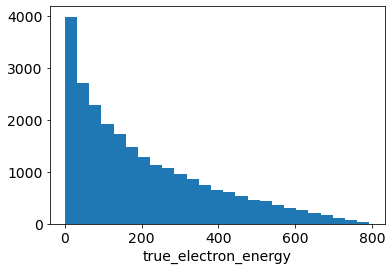

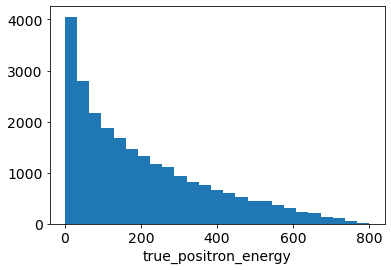

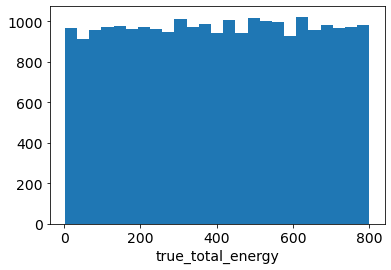

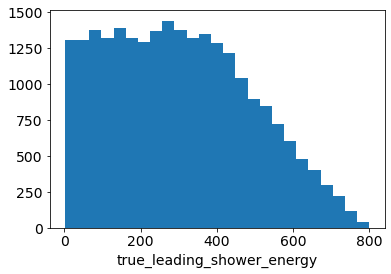

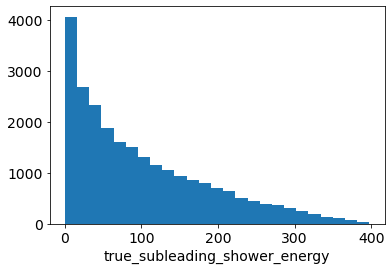

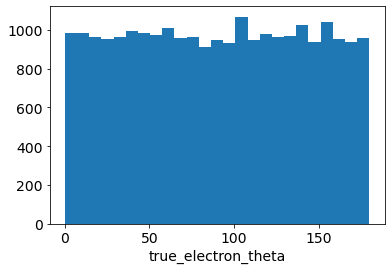

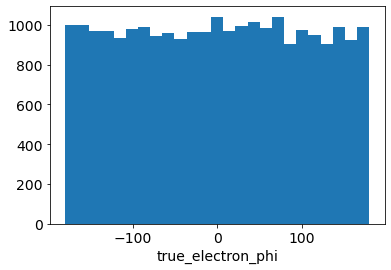

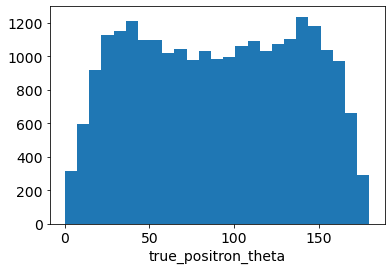

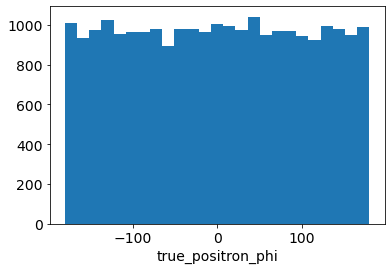

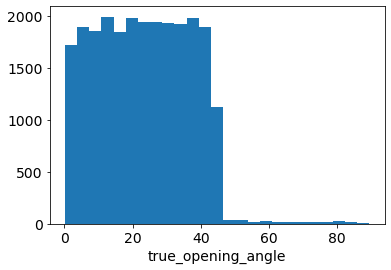

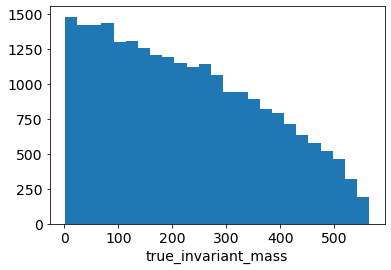

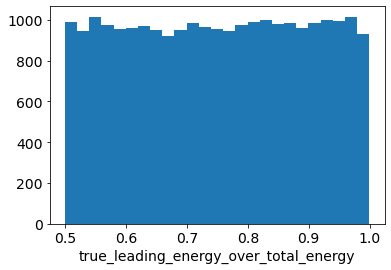

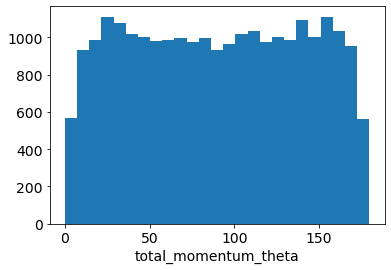

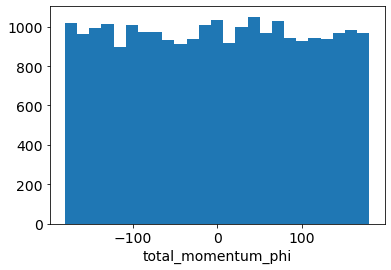

In [14]:
mpl.rcParams.update({'font.size': 14})

plt.figure()
plt.hist(isotropic_df["true_electron_energy"].to_numpy(), bins=25)
plt.xlabel("true_electron_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_positron_energy"].to_numpy(), bins=25)
plt.xlabel("true_positron_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_total_energy"].to_numpy(), bins=25)
plt.xlabel("true_total_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_leading_shower_energy"].to_numpy(), bins=25)
plt.xlabel("true_leading_shower_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_subleading_shower_energy"].to_numpy(), bins=25)
plt.xlabel("true_subleading_shower_energy")
plt.show()


plt.figure()
plt.hist(isotropic_df["true_electron_theta"].to_numpy(), bins=25)
plt.xlabel("true_electron_theta")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_electron_phi"].to_numpy(), bins=25)
plt.xlabel("true_electron_phi")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_positron_theta"].to_numpy(), bins=25)
plt.xlabel("true_positron_theta")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_positron_phi"].to_numpy(), bins=25)
plt.xlabel("true_positron_phi")
plt.show()


plt.figure()
plt.hist(isotropic_df["true_opening_angle"].to_numpy(), bins=25)
plt.xlabel("true_opening_angle")
plt.show()


plt.figure()
plt.hist(isotropic_df["true_invariant_mass"].to_numpy(), bins=25)
plt.xlabel("true_invariant_mass")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_leading_energy_over_total_energy"].to_numpy(), bins=25)
plt.xlabel("true_leading_energy_over_total_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["total_momentum_theta"].to_numpy(), bins=25)
plt.xlabel("total_momentum_theta")
plt.show()

plt.figure()
plt.hist(isotropic_df["total_momentum_phi"].to_numpy(), bins=25)
plt.xlabel("total_momentum_phi")
plt.show()


In [15]:
print(isotropic_df.shape[0])
isotropic_df = isotropic_df.query("true_opening_angle < 10 and true_leading_energy_over_total_energy<0.6")
print(isotropic_df.shape[0])

24288
1052


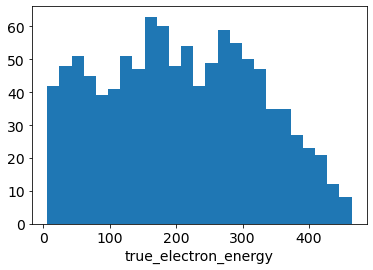

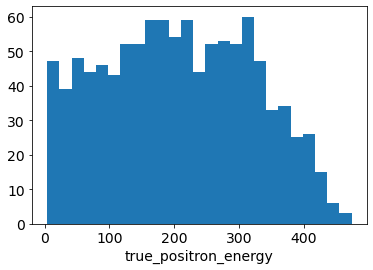

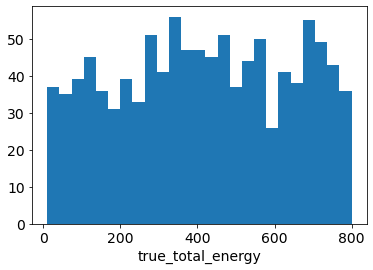

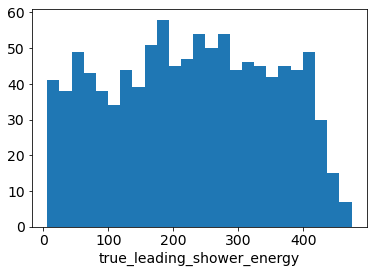

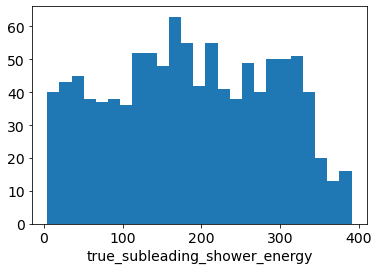

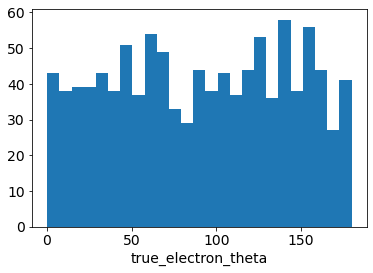

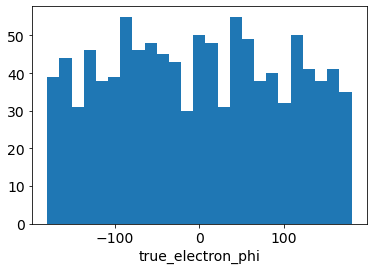

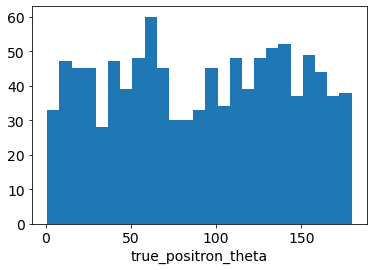

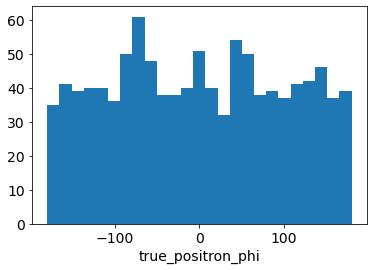

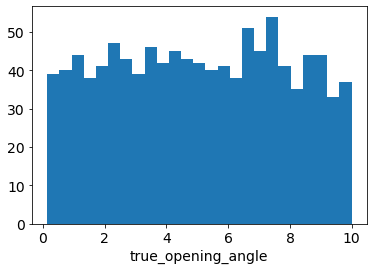

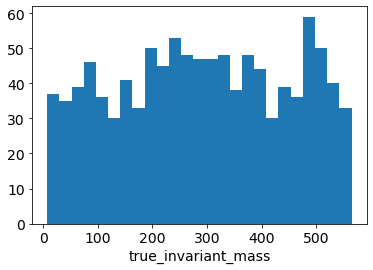

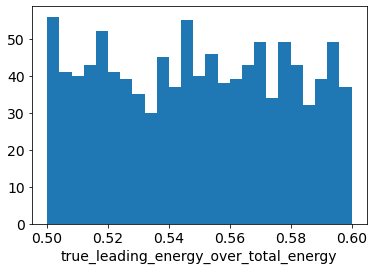

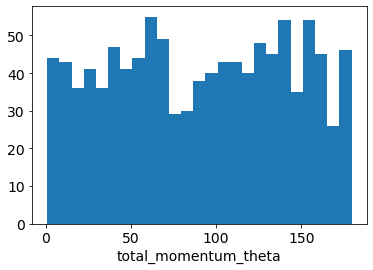

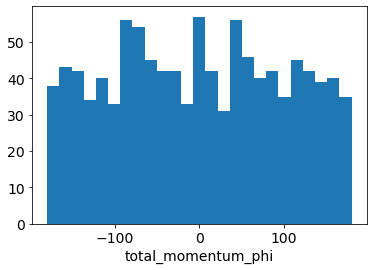

In [16]:
mpl.rcParams.update({'font.size': 14})

plt.figure()
plt.hist(isotropic_df["true_electron_energy"].to_numpy(), bins=25)
plt.xlabel("true_electron_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_positron_energy"].to_numpy(), bins=25)
plt.xlabel("true_positron_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_total_energy"].to_numpy(), bins=25)
plt.xlabel("true_total_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_leading_shower_energy"].to_numpy(), bins=25)
plt.xlabel("true_leading_shower_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_subleading_shower_energy"].to_numpy(), bins=25)
plt.xlabel("true_subleading_shower_energy")
plt.show()


plt.figure()
plt.hist(isotropic_df["true_electron_theta"].to_numpy(), bins=25)
plt.xlabel("true_electron_theta")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_electron_phi"].to_numpy(), bins=25)
plt.xlabel("true_electron_phi")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_positron_theta"].to_numpy(), bins=25)
plt.xlabel("true_positron_theta")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_positron_phi"].to_numpy(), bins=25)
plt.xlabel("true_positron_phi")
plt.show()


plt.figure()
plt.hist(isotropic_df["true_opening_angle"].to_numpy(), bins=25)
plt.xlabel("true_opening_angle")
plt.show()


plt.figure()
plt.hist(isotropic_df["true_invariant_mass"].to_numpy(), bins=25)
plt.xlabel("true_invariant_mass")
plt.show()

plt.figure()
plt.hist(isotropic_df["true_leading_energy_over_total_energy"].to_numpy(), bins=25)
plt.xlabel("true_leading_energy_over_total_energy")
plt.show()

plt.figure()
plt.hist(isotropic_df["total_momentum_theta"].to_numpy(), bins=25)
plt.xlabel("total_momentum_theta")
plt.show()

plt.figure()
plt.hist(isotropic_df["total_momentum_phi"].to_numpy(), bins=25)
plt.xlabel("total_momentum_phi")
plt.show()


In [17]:

# loading NC Delta files

# not applying any FC or generic selection at this stage, because an efficiency calculation is done later to get the scaling factors

#f_nc_delta_run1 = uproot.open("data/processed_checkout_rootfiles/checkout_prodgenie_nc_delta_overlay_run1.root")["wcpselection"]
#f_nc_delta_run1 = uproot.open("data/processed_checkout_rootfiles/checkout_prodgenie_nc_delta_overlay_run1_PF.root")["wcpselection"]
#f_nc_delta_run1 = uproot.open("data/processed_checkout_rootfiles/checkout_prodgenie_bnb_nc_delta_overlay_run1_PF.root")["wcpselection"]
f_nc_delta_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nc_delta_overlay_run1_PF.root")["wcpselection"]
#print(f_nc_delta_run1.keys())
#f_nc_delta_run1["T_KINEvars"].show()
f_nc_delta_run1_bdt = f_nc_delta_run1["T_BDTvars"].pandas.df(bdt_vars + ["nc_delta_score"], flatten=False) # adding this score value temporarily to compare
f_nc_delta_run1_eval = f_nc_delta_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nc_delta_run1_pfeval = f_nc_delta_run1["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nc_delta_run1_kine = f_nc_delta_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nc_delta_run1_pot = f_nc_delta_run1["T_pot"].pandas.df(["subRunNo", "pot_tor875good"], flatten=False).query(
    "subRunNo % 2 == 1") # EXCLUDING TRAINING EVENTS FOR POT COUNTING
nc_delta_run1_file_POT = np.sum(f_nc_delta_run1_pot["pot_tor875good"].to_numpy())
nc_delta_run1_df = pd.concat([f_nc_delta_run1_bdt, f_nc_delta_run1_eval, f_nc_delta_run1_pfeval, f_nc_delta_run1_kine], axis=1, sort=False).query(
    "subrun%2==1") # EXCLUDING TRAINING EVENTS  
del f_nc_delta_run1
del f_nc_delta_run1_bdt
del f_nc_delta_run1_eval
del f_nc_delta_run1_pfeval
del f_nc_delta_run1_kine
del f_nc_delta_run1_pot
nc_delta_run1_df["isEXT"] = [0 for i in range(nc_delta_run1_df.shape[0])]
nc_delta_run1_df["isDirt"] = [0 for i in range(nc_delta_run1_df.shape[0])]
nc_delta_run1_df["WC_file"] = ["nc_delta_run1" for i in range(nc_delta_run1_df.shape[0])]
nc_delta_run1_df["run_num"] = [1 for i in range(nc_delta_run1_df.shape[0])]

print(nc_delta_run1_file_POT)
print(nc_delta_run1_df.shape[0])

f_nc_delta_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nc_delta_overlay_run2_PF.root")["wcpselection"]
f_nc_delta_run2_bdt = f_nc_delta_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nc_delta_run2_eval = f_nc_delta_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nc_delta_run2_pfeval = f_nc_delta_run2["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nc_delta_run2_kine = f_nc_delta_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nc_delta_run2_pot = f_nc_delta_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_delta_run2_file_POT = np.sum(f_nc_delta_run2_pot["pot_tor875good"].to_numpy())
nc_delta_run2_df = pd.concat([f_nc_delta_run2_bdt, f_nc_delta_run2_eval, f_nc_delta_run2_pfeval, f_nc_delta_run2_kine], axis=1, sort=False)
del f_nc_delta_run2
del f_nc_delta_run2_bdt
del f_nc_delta_run2_eval
del f_nc_delta_run2_pfeval
del f_nc_delta_run2_kine
del f_nc_delta_run2_pot
nc_delta_run2_df["isEXT"] = [0 for i in range(nc_delta_run2_df.shape[0])]
nc_delta_run2_df["isDirt"] = [0 for i in range(nc_delta_run2_df.shape[0])]
nc_delta_run2_df["WC_file"] = ["nc_delta_run2" for i in range(nc_delta_run2_df.shape[0])]
nc_delta_run2_df["run_num"] = [2 for i in range(nc_delta_run2_df.shape[0])]

print(nc_delta_run2_file_POT)
print(nc_delta_run2_df.shape[0])

f_nc_delta_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nc_delta_overlay_run2_PF.root")["wcpselection"]
f_nc_delta_run3_bdt = f_nc_delta_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nc_delta_run3_eval = f_nc_delta_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nc_delta_run3_pfeval = f_nc_delta_run3["T_PFeval"].pandas.df(pf_eval_mc_variables + dedicated_pf_eval_mc_variables, flatten=False)
f_nc_delta_run3_kine = f_nc_delta_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nc_delta_run3_pot = f_nc_delta_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_delta_run3_file_POT = np.sum(f_nc_delta_run3_pot["pot_tor875good"].to_numpy())
nc_delta_run3_df = pd.concat([f_nc_delta_run3_bdt, f_nc_delta_run3_eval, f_nc_delta_run3_pfeval, f_nc_delta_run3_kine], axis=1, sort=False)
del f_nc_delta_run3
del f_nc_delta_run3_bdt
del f_nc_delta_run3_eval
del f_nc_delta_run3_pfeval
del f_nc_delta_run3_kine
del f_nc_delta_run3_pot
nc_delta_run3_df["isEXT"] = [0 for i in range(nc_delta_run3_df.shape[0])]
nc_delta_run3_df["isDirt"] = [0 for i in range(nc_delta_run3_df.shape[0])]
nc_delta_run3_df["WC_file"] = ["nc_delta_run3" for i in range(nc_delta_run3_df.shape[0])]
nc_delta_run3_df["run_num"] = [3 for i in range(nc_delta_run3_df.shape[0])]

print(nc_delta_run3_file_POT)
print(nc_delta_run3_df.shape[0])
    

nc_delta_df = pd.concat([nc_delta_run1_df, nc_delta_run2_df, nc_delta_run3_df], sort=False).query("truth_isCC==0 and truth_NCDelta==1")

nc_delta_df.rename(columns={'nc_delta_score': 'saved_nc_delta_score'}, inplace=True)

del nc_delta_run1_df
del nc_delta_run2_df
del nc_delta_run3_df


2.157796657242789e+23
46967
4.7398996193248585e+23
101199
4.7398996193248585e+23
101199


In [18]:
# adding truth primary particle nums, only for NC Delta

num_prim_photons = []
num_prim_protons = []
num_prim_charged_pions = []
num_prim_neutrons = []
num_prim_electrons = []
num_prim_muons = []
num_prim_pi0s = []
num_prim_others = []

max_proton_true_kinetic_energies = []
max_pion_true_kinetic_energies = []

photon_thetas = []
photon_phis = []
photon_energies = []

runnum = nc_delta_df["run_num"].to_numpy()
run = nc_delta_df["run"].to_numpy()
subrun = nc_delta_df["subrun"].to_numpy()
event = nc_delta_df["event"].to_numpy()

truth_pdgs = nc_delta_df["truth_pdg"].to_numpy()
truth_mothers = nc_delta_df["truth_mother"].to_numpy()
truth_startMomentums = nc_delta_df["truth_startMomentum"].to_numpy()

for i in tqdm(range(nc_delta_df.shape[0])):

    num_prim_photon = 0
    num_prim_proton = 0
    num_prim_charged_pion = 0
    num_prim_neutron = 0
    num_prim_electron = 0
    num_prim_muon = 0
    num_prim_pi0 = 0
    num_prim_other = 0
    
    max_pion_true_kinetic_energy = 0
    max_proton_true_kinetic_energy = 0

    photon_theta = np.nan
    photon_phi = np.nan
    photon_energy = np.nan
    
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]

    for j in range(len(truth_pdg_list)):

        photon_angle_found = False

        if truth_mother_list[j] != 0: # non-primary
            continue
        if abs(truth_pdg_list[j]) == 12 or abs(truth_pdg_list[j]) == 14: # primary neutrino (exiting NC interaction)
            continue
        elif truth_pdg_list[j] == 22:
            num_prim_photon += 1

            if not photon_angle_found:

                photon_4_momentum = truth_startMomentum_list[j]

                if photon_4_momentum[3] > 0:
                    photon_momentum_perp = np.sqrt(photon_4_momentum[0] * photon_4_momentum[0] + photon_4_momentum[1] * photon_4_momentum[1])
                    photon_theta = np.arctan2(photon_momentum_perp, photon_4_momentum[2]) * 180. / np.pi
                    photon_phi = np.arctan2(photon_4_momentum[0], photon_4_momentum[1]) * 180. / np.pi
                    photon_energy = photon_4_momentum[3] * 1000.

                photon_angle_found = True

        elif truth_pdg_list[j] == 2212:
            num_prim_proton += 1
            
            proton_kinetic_energy = 1000. * truth_startMomentum_list[j][3] - 938.272
            max_proton_true_kinetic_energy = max(max_proton_true_kinetic_energy, proton_kinetic_energy)
            
        elif abs(truth_pdg_list[j]) == 211:
            num_prim_charged_pion += 1
            
            pion_kinetic_energy = 1000. * truth_startMomentum_list[j][3] - 139.570
            max_pion_true_kinetic_energy = max(max_pion_true_kinetic_energy, pion_kinetic_energy)
            
        elif truth_pdg_list[j] == 2112:
            num_prim_neutron += 1
        elif abs(truth_pdg_list[j]) == 11:
            num_prim_electron += 1
        elif abs(truth_pdg_list[j]) == 13:
            num_prim_muon += 1
        elif truth_pdg_list[j] == 111:
            num_prim_pi0 += 1
        else:
            num_prim_other += 1
            print(truth_pdg_list[j])


    num_prim_photons.append(num_prim_photon)
    num_prim_protons.append(num_prim_proton)
    num_prim_charged_pions.append(num_prim_charged_pion)
    num_prim_neutrons.append(num_prim_neutron)
    num_prim_electrons.append(num_prim_electron)
    num_prim_muons.append(num_prim_muon)
    num_prim_pi0s.append(num_prim_pi0)
    num_prim_others.append(num_prim_other)
    
    max_proton_true_kinetic_energies.append(max_proton_true_kinetic_energy)
    max_pion_true_kinetic_energies.append(max_pion_true_kinetic_energy)

    photon_thetas.append(photon_theta)
    photon_phis.append(photon_phi)
    photon_energies.append(photon_energy)

nc_delta_df["num_prim_photons"] = num_prim_photons
nc_delta_df["num_prim_protons"] = num_prim_protons
nc_delta_df["num_prim_charged_pions"] = num_prim_charged_pions
nc_delta_df["num_prim_neutrons"] = num_prim_neutrons
nc_delta_df["num_prim_electrons"] = num_prim_electrons
nc_delta_df["num_prim_muons"] = num_prim_muons
nc_delta_df["num_prim_pi0s"] = num_prim_pi0s
nc_delta_df["num_prim_others"] = num_prim_others

nc_delta_df["max_proton_true_kinetic_energy"] = max_proton_true_kinetic_energies
nc_delta_df["max_pion_true_kinetic_energy"] = max_pion_true_kinetic_energies

nc_delta_df["prim_photon_theta"] = photon_thetas
nc_delta_df["prim_photon_phi"] = photon_phis
nc_delta_df["prim_photon_energy"] = photon_energies

100%|████████████████████████████████████████████████████████████████████████████████| 249365/249365 [00:29<00:00, 8480.87it/s]


In [19]:
# loading WC NC Pi0 files

f_ncpi0_run1 = uproot.open(wc_file_location + "checkout_prodgenie_nc_pi0_overlay_run1_PF.root")["wcpselection"]
f_ncpi0_run1_bdt = f_ncpi0_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ncpi0_run1_eval = f_ncpi0_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_ncpi0_run1_pfeval = f_ncpi0_run1["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_ncpi0_run1_kine = f_ncpi0_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ncpi0_run1_pot = f_ncpi0_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_pi0_run1_file_POT = np.sum(f_ncpi0_run1_pot["pot_tor875good"].to_numpy())
nc_pi0_run1_df = pd.concat([f_ncpi0_run1_bdt, f_ncpi0_run1_eval, f_ncpi0_run1_pfeval, f_ncpi0_run1_kine], axis=1, sort=False)
del f_ncpi0_run1
del f_ncpi0_run1_bdt
del f_ncpi0_run1_eval
del f_ncpi0_run1_pfeval
del f_ncpi0_run1_kine
del f_ncpi0_run1_pot
nc_pi0_run1_df["isEXT"] = [0 for i in range(nc_pi0_run1_df.shape[0])]
nc_pi0_run1_df["isDirt"] = [0 for i in range(nc_pi0_run1_df.shape[0])]
nc_pi0_run1_df["WC_file"] = ["NC_Pi0_run1" for i in range(nc_pi0_run1_df.shape[0])]
nc_pi0_run1_df["run_num"] = [1 for i in range(nc_pi0_run1_df.shape[0])]

f_ncpi0_run2 = uproot.open(wc_file_location + "checkout_prodgenie_nc_pi0_overlay_run2_PF.root")["wcpselection"]
f_ncpi0_run2_bdt = f_ncpi0_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ncpi0_run2_eval = f_ncpi0_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_ncpi0_run2_pfeval = f_ncpi0_run2["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_ncpi0_run2_kine = f_ncpi0_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ncpi0_run2_pot = f_ncpi0_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_pi0_run2_file_POT = np.sum(f_ncpi0_run2_pot["pot_tor875good"].to_numpy())
nc_pi0_run2_df = pd.concat([f_ncpi0_run2_bdt, f_ncpi0_run2_eval, f_ncpi0_run2_pfeval, f_ncpi0_run2_kine], axis=1, sort=False)
del f_ncpi0_run2
del f_ncpi0_run2_bdt
del f_ncpi0_run2_eval
del f_ncpi0_run2_pfeval
del f_ncpi0_run2_kine
del f_ncpi0_run2_pot
nc_pi0_run2_df["isEXT"] = [0 for i in range(nc_pi0_run2_df.shape[0])]
nc_pi0_run2_df["isDirt"] = [0 for i in range(nc_pi0_run2_df.shape[0])]
nc_pi0_run2_df["WC_file"] = ["NC_Pi0_run2" for i in range(nc_pi0_run2_df.shape[0])]
nc_pi0_run2_df["run_num"] = [2 for i in range(nc_pi0_run2_df.shape[0])]


f_ncpi0_run3 = uproot.open(wc_file_location + "checkout_prodgenie_nc_pi0_overlay_run3_PF.root")["wcpselection"]
f_ncpi0_run3_bdt = f_ncpi0_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ncpi0_run3_eval = f_ncpi0_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_ncpi0_run3_pfeval = f_ncpi0_run3["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_ncpi0_run3_kine = f_ncpi0_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ncpi0_run3_pot = f_ncpi0_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nc_pi0_run3_file_POT = np.sum(f_ncpi0_run3_pot["pot_tor875good"].to_numpy())
nc_pi0_run3_df = pd.concat([f_ncpi0_run3_bdt, f_ncpi0_run3_eval, f_ncpi0_run3_pfeval, f_ncpi0_run3_kine], axis=1, sort=False)
del f_ncpi0_run3
del f_ncpi0_run3_bdt
del f_ncpi0_run3_eval
del f_ncpi0_run3_pfeval
del f_ncpi0_run3_kine
del f_ncpi0_run3_pot
nc_pi0_run3_df["isEXT"] = [0 for i in range(nc_pi0_run3_df.shape[0])]
nc_pi0_run3_df["isDirt"] = [0 for i in range(nc_pi0_run3_df.shape[0])]
nc_pi0_run3_df["WC_file"] = ["NC_Pi0_run3" for i in range(nc_pi0_run3_df.shape[0])]
nc_pi0_run3_df["run_num"] = [3 for i in range(nc_pi0_run3_df.shape[0])]

print(nc_pi0_run1_file_POT)
print(nc_pi0_run1_df.shape[0])

print(nc_pi0_run3_file_POT)
print(nc_pi0_run3_df.shape[0])

nc_pi0_df = pd.concat([nc_pi0_run1_df, nc_pi0_run2_df, nc_pi0_run3_df], sort=False).query("truth_isCC==0 and truth_NprimPio>0"
                                                                + " and not (truth_NCDelta==1) and kine_reco_Enu > 0 and match_isFC==1")

del nc_pi0_run1_df
del nc_pi0_run2_df
del nc_pi0_run3_df

1.224676151063279e+21
48005
1.2277865498371458e+21
47066


In [20]:
# loading WC nue overlay files

f_intrinsic_nue_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run1_PF.root")["wcpselection"]
f_intrinsic_nue_run1_bdt = f_intrinsic_nue_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run1_eval = f_intrinsic_nue_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run1_pfeval = f_intrinsic_nue_run1["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run1_kine = f_intrinsic_nue_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run1_pot = f_intrinsic_nue_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run1_file_POT = np.sum(f_intrinsic_nue_run1_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run1_df = pd.concat([f_intrinsic_nue_run1_bdt, f_intrinsic_nue_run1_eval, f_intrinsic_nue_run1_pfeval, f_intrinsic_nue_run1_kine], axis=1, sort=False)
del f_intrinsic_nue_run1
del f_intrinsic_nue_run1_bdt
del f_intrinsic_nue_run1_eval
del f_intrinsic_nue_run1_pfeval
del f_intrinsic_nue_run1_kine
del f_intrinsic_nue_run1_pot
intrinsic_nue_run1_df["isEXT"] = [0 for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["isDirt"] = [0 for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["WC_file"] = ["intrinsic_nue_run1" for i in range(intrinsic_nue_run1_df.shape[0])]
intrinsic_nue_run1_df["run_num"] = [1 for i in range(intrinsic_nue_run1_df.shape[0])]

print(intrinsic_nue_run1_file_POT)
print(intrinsic_nue_run1_df.shape[0])

f_intrinsic_nue_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run2_PF.root")["wcpselection"]
f_intrinsic_nue_run2_bdt = f_intrinsic_nue_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run2_eval = f_intrinsic_nue_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run2_pfeval = f_intrinsic_nue_run2["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run2_kine = f_intrinsic_nue_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run2_pot = f_intrinsic_nue_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run2_file_POT = np.sum(f_intrinsic_nue_run2_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run2_df = pd.concat([f_intrinsic_nue_run2_bdt, f_intrinsic_nue_run2_eval, f_intrinsic_nue_run2_pfeval, f_intrinsic_nue_run2_kine], axis=1, sort=False)
del f_intrinsic_nue_run2
del f_intrinsic_nue_run2_bdt
del f_intrinsic_nue_run2_eval
del f_intrinsic_nue_run2_pfeval
del f_intrinsic_nue_run2_kine
del f_intrinsic_nue_run2_pot
intrinsic_nue_run2_df["isEXT"] = [0 for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["isDirt"] = [0 for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["WC_file"] = ["intrinsic_nue_run2" for i in range(intrinsic_nue_run2_df.shape[0])]
intrinsic_nue_run2_df["run_num"] = [2 for i in range(intrinsic_nue_run2_df.shape[0])]

print(intrinsic_nue_run2_file_POT)
print(intrinsic_nue_run2_df.shape[0])

f_intrinsic_nue_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_intrinsic_nue_overlay_run3_PF.root")["wcpselection"]
f_intrinsic_nue_run3_bdt = f_intrinsic_nue_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_intrinsic_nue_run3_eval = f_intrinsic_nue_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_intrinsic_nue_run3_pfeval = f_intrinsic_nue_run3["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_intrinsic_nue_run3_kine = f_intrinsic_nue_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_intrinsic_nue_run3_pot = f_intrinsic_nue_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
intrinsic_nue_run3_file_POT = np.sum(f_intrinsic_nue_run3_pot["pot_tor875good"].to_numpy())
intrinsic_nue_run3_df = pd.concat([f_intrinsic_nue_run3_bdt, f_intrinsic_nue_run3_eval, f_intrinsic_nue_run3_pfeval, f_intrinsic_nue_run3_kine], axis=1, sort=False)
del f_intrinsic_nue_run3
del f_intrinsic_nue_run3_bdt
del f_intrinsic_nue_run3_eval
del f_intrinsic_nue_run3_pfeval
del f_intrinsic_nue_run3_kine
del f_intrinsic_nue_run3_pot
intrinsic_nue_run3_df["isEXT"] = [0 for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["isDirt"] = [0 for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["WC_file"] = ["intrinsic_nue_run3" for i in range(intrinsic_nue_run3_df.shape[0])]
intrinsic_nue_run3_df["run_num"] = [3 for i in range(intrinsic_nue_run3_df.shape[0])]

print(intrinsic_nue_run3_file_POT)
print(intrinsic_nue_run3_df.shape[0])

intrinsic_nue_df = pd.concat([intrinsic_nue_run1_df, intrinsic_nue_run2_df, intrinsic_nue_run3_df], sort=False).query(
    "truth_isCC==1 and abs(truth_nuPdg)==12 and kine_reco_Enu > 0 and match_isFC==1")

del intrinsic_nue_run1_df
del intrinsic_nue_run2_df
del intrinsic_nue_run3_df


3.931094470783121e+22
68206
1.2460289446544576e+23
209160
8.821478522260567e+22
148962


In [21]:
# loading WC nu overlay files

f_nu_overlay_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"]
f_nu_overlay_run1_bdt = f_nu_overlay_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run1_eval = f_nu_overlay_run1["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run1_pfeval = f_nu_overlay_run1["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_nu_overlay_run1_kine = f_nu_overlay_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run1_pot = f_nu_overlay_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run1_POT = np.sum(f_nu_overlay_run1_pot["pot_tor875good"].to_numpy())
nu_overlay_run1_df = pd.concat([f_nu_overlay_run1_bdt, f_nu_overlay_run1_eval, f_nu_overlay_run1_pfeval, f_nu_overlay_run1_kine], axis=1, sort=False)
del f_nu_overlay_run1
del f_nu_overlay_run1_bdt
del f_nu_overlay_run1_eval
del f_nu_overlay_run1_pfeval
del f_nu_overlay_run1_kine
del f_nu_overlay_run1_pot
nu_overlay_run1_df["isEXT"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["isDirt"] = [0 for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["WC_file"] = ["nu_overlay_run1" for i in range(nu_overlay_run1_df.shape[0])]
nu_overlay_run1_df["run_num"] = [1 for i in range(nu_overlay_run1_df.shape[0])]

f_nu_overlay_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run2_PF.root")["wcpselection"]
f_nu_overlay_run2_bdt = f_nu_overlay_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run2_eval = f_nu_overlay_run2["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run2_pfeval = f_nu_overlay_run2["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_nu_overlay_run2_kine = f_nu_overlay_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run2_pot = f_nu_overlay_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run2_POT = np.sum(f_nu_overlay_run2_pot["pot_tor875good"].to_numpy())
nu_overlay_run2_df = pd.concat([f_nu_overlay_run2_bdt, f_nu_overlay_run2_eval, f_nu_overlay_run2_pfeval, f_nu_overlay_run2_kine], axis=1, sort=False)
del f_nu_overlay_run2
del f_nu_overlay_run2_bdt
del f_nu_overlay_run2_eval
del f_nu_overlay_run2_pfeval
del f_nu_overlay_run2_kine
del f_nu_overlay_run2_pot
nu_overlay_run2_df["isEXT"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["isDirt"] = [0 for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["WC_file"] = ["nu_overlay_run2" for i in range(nu_overlay_run2_df.shape[0])]
nu_overlay_run2_df["run_num"] = [2 for i in range(nu_overlay_run2_df.shape[0])]

f_nu_overlay_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_nu_overlay_run3_PF.root")["wcpselection"]
f_nu_overlay_run3_bdt = f_nu_overlay_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_nu_overlay_run3_eval = f_nu_overlay_run3["T_eval"].pandas.df(eval_mc_variables + ["match_isFC"], flatten=False)
f_nu_overlay_run3_pfeval = f_nu_overlay_run3["T_PFeval"].pandas.df(pf_eval_mc_variables, flatten=False)
f_nu_overlay_run3_kine = f_nu_overlay_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_nu_overlay_run3_pot = f_nu_overlay_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
nu_overlay_run3_POT = np.sum(f_nu_overlay_run3_pot["pot_tor875good"].to_numpy())
nu_overlay_run3_df = pd.concat([f_nu_overlay_run3_bdt, f_nu_overlay_run3_eval, f_nu_overlay_run3_pfeval, f_nu_overlay_run3_kine], axis=1, sort=False)
del f_nu_overlay_run3
del f_nu_overlay_run3_bdt
del f_nu_overlay_run3_eval
del f_nu_overlay_run3_pfeval
del f_nu_overlay_run3_kine
del f_nu_overlay_run3_pot
nu_overlay_run3_df["isEXT"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["isDirt"] = [0 for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["WC_file"] = ["nu_overlay_run3" for i in range(nu_overlay_run3_df.shape[0])]
nu_overlay_run3_df["run_num"] = [3 for i in range(nu_overlay_run3_df.shape[0])]

overlay_df = pd.concat([nu_overlay_run1_df, nu_overlay_run2_df, nu_overlay_run3_df], sort=False).query(
    "not (truth_isCC==0 and truth_NCDelta==1) and not (truth_isCC==0 and truth_NprimPio>0 and not (truth_NCDelta==1))"
    + " and not (truth_isCC==1 and abs(truth_nuPdg)==12) and kine_reco_Enu > 0 and match_isFC==1")
del nu_overlay_run1_df
del nu_overlay_run2_df
del nu_overlay_run3_df

In [22]:
# loading WC EXT files

#f_ext_run1 = uproot.open(wc_file_location + "wcp_data_extbnb_run1_mcc9_v08_00_00_53_checkout.root")["wcpselection"] # has wrong POT info
f_ext_run1 = uproot.open(wc_file_location + "checkout_data_extbnb_run1_PF.root")["wcpselection"]
f_ext_run1_bdt = f_ext_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run1_eval = f_ext_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run1_pfeval = f_ext_run1["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run1_kine = f_ext_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run1_pot = f_ext_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run1_POT = np.sum(f_ext_run1_pot["pot_tor875good"].to_numpy())
ext_run1_df = pd.concat([f_ext_run1_bdt, f_ext_run1_eval, f_ext_run1_pfeval, f_ext_run1_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run1
del f_ext_run1_bdt
del f_ext_run1_eval
del f_ext_run1_pfeval
del f_ext_run1_kine
del f_ext_run1_pot
ext_run1_df["isEXT"] = [1 for i in range(ext_run1_df.shape[0])]
ext_run1_df["isDirt"] = [0 for i in range(ext_run1_df.shape[0])]
ext_run1_df["WC_file"] = ["ext_run1" for i in range(ext_run1_df.shape[0])]
ext_run1_df["run_num"] = [1 for i in range(ext_run1_df.shape[0])]

f_ext_run2 = uproot.open(wc_file_location + "checkout_data_extbnb_run2_PF.root")["wcpselection"]
f_ext_run2_bdt = f_ext_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run2_eval = f_ext_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run2_pfeval = f_ext_run2["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run2_kine = f_ext_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run2_pot = f_ext_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run2_POT = np.sum(f_ext_run2_pot["pot_tor875good"].to_numpy())
ext_run2_df = pd.concat([f_ext_run2_bdt, f_ext_run2_eval, f_ext_run2_pfeval, f_ext_run2_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run2
del f_ext_run2_bdt
del f_ext_run2_eval
del f_ext_run2_pfeval
del f_ext_run2_kine
del f_ext_run2_pot
ext_run2_df["isEXT"] = [1 for i in range(ext_run2_df.shape[0])]
ext_run2_df["isDirt"] = [0 for i in range(ext_run2_df.shape[0])]
ext_run2_df["WC_file"] = ["ext_run2" for i in range(ext_run2_df.shape[0])]
ext_run2_df["run_num"] = [2 for i in range(ext_run2_df.shape[0])]

f_ext_run3 = uproot.open(wc_file_location + "checkout_data_extbnb_run3_PF.root")["wcpselection"]
f_ext_run3_bdt = f_ext_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_ext_run3_eval = f_ext_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_ext_run3_pfeval = f_ext_run3["T_PFeval"].pandas.df(pf_eval_data_variables_no_pf_info, flatten=False)
f_ext_run3_kine = f_ext_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_ext_run3_pot = f_ext_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
ext_run3_POT = np.sum(f_ext_run3_pot["pot_tor875good"].to_numpy())
ext_run3_df = pd.concat([f_ext_run3_bdt, f_ext_run3_eval, f_ext_run3_pfeval, f_ext_run3_kine], axis=1, sort=False).query("kine_reco_Enu > 0")
del f_ext_run3
del f_ext_run3_bdt
del f_ext_run3_eval
del f_ext_run3_pfeval
del f_ext_run3_kine
del f_ext_run3_pot
ext_run3_df["isEXT"] = [1 for i in range(ext_run3_df.shape[0])]
ext_run3_df["isDirt"] = [0 for i in range(ext_run3_df.shape[0])]
ext_run3_df["WC_file"] = ["ext_run3" for i in range(ext_run3_df.shape[0])]
ext_run3_df["run_num"] = [3 for i in range(ext_run3_df.shape[0])]

print(ext_run1_POT, ext_run2_POT, ext_run3_POT)
print(ext_run1_df.shape[0], ext_run2_df.shape[0], ext_run3_df.shape[0])

ext_df = pd.concat([ext_run1_df, ext_run2_df, ext_run3_df], sort=False)
del ext_run1_df
del ext_run2_df
del ext_run3_df

# fixing POTs, from lee_fit configurations/cv_input.txt, technically using different files but I think it should be pretty much the same.
# pot_counting didn't work, pot_counting_mc gave way too low numbers.
ext_run1_POT = 2.21814e+20
ext_run2_POT = 6.25014e+20
ext_run3_POT = 7.4127e+20

print("\nfixed:")
print(ext_run1_POT, ext_run2_POT, ext_run3_POT)



84730946.0921828 289727438.0184046 0.0
9984 28818 33066

fixed:
2.21814e+20 6.25014e+20 7.4127e+20


In [23]:
# loading WC dirt files

f_dirt_run1 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run1_PF.root")["wcpselection"]
f_dirt_run1_bdt = f_dirt_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run1_eval = f_dirt_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run1_pfeval = f_dirt_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run1_kine = f_dirt_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run1_pot = f_dirt_run1["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run1_POT = np.sum(f_dirt_run1_pot["pot_tor875good"].to_numpy())
dirt_run1_df = pd.concat([f_dirt_run1_bdt, f_dirt_run1_eval, f_dirt_run1_pfeval, f_dirt_run1_kine], axis=1, sort=False)
del f_dirt_run1
del f_dirt_run1_bdt
del f_dirt_run1_eval
del f_dirt_run1_pfeval
del f_dirt_run1_kine
del f_dirt_run1_pot
dirt_run1_df["isEXT"] = [0 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["isDirt"] = [1 for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["WC_file"] = ["dirt_run1" for i in range(dirt_run1_df.shape[0])]
dirt_run1_df["run_num"] = [1 for i in range(dirt_run1_df.shape[0])]

f_dirt_run2 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run2_PF.root")["wcpselection"]
f_dirt_run2_bdt = f_dirt_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run2_eval = f_dirt_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run2_pfeval = f_dirt_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run2_kine = f_dirt_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run2_pot = f_dirt_run2["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run2_POT = np.sum(f_dirt_run2_pot["pot_tor875good"].to_numpy())
dirt_run2_df = pd.concat([f_dirt_run2_bdt, f_dirt_run2_eval, f_dirt_run2_pfeval, f_dirt_run2_kine], axis=1, sort=False)
del f_dirt_run2
del f_dirt_run2_bdt
del f_dirt_run2_eval
del f_dirt_run2_pfeval
del f_dirt_run2_kine
del f_dirt_run2_pot
dirt_run2_df["isEXT"] = [0 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["isDirt"] = [1 for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["WC_file"] = ["dirt_run2" for i in range(dirt_run2_df.shape[0])]
dirt_run2_df["run_num"] = [2 for i in range(dirt_run2_df.shape[0])]

f_dirt_run3 = uproot.open(wc_file_location + "checkout_prodgenie_bnb_dirt_overlay_run3_PF.root")["wcpselection"]
f_dirt_run3_bdt = f_dirt_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_dirt_run3_eval = f_dirt_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_dirt_run3_pfeval = f_dirt_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_dirt_run3_kine = f_dirt_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
f_dirt_run3_pot = f_dirt_run3["T_pot"].pandas.df("pot_tor875good", flatten=False)
dirt_run3_POT = np.sum(f_dirt_run3_pot["pot_tor875good"].to_numpy())
dirt_run3_df = pd.concat([f_dirt_run3_bdt, f_dirt_run3_eval, f_dirt_run3_pfeval, f_dirt_run3_kine], axis=1, sort=False)
del f_dirt_run3
del f_dirt_run3_bdt
del f_dirt_run3_eval
del f_dirt_run3_pfeval
del f_dirt_run3_kine
del f_dirt_run3_pot
dirt_run3_df["isEXT"] = [0 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["isDirt"] = [1 for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["WC_file"] = ["dirt_run3" for i in range(dirt_run3_df.shape[0])]
dirt_run3_df["run_num"] = [3 for i in range(dirt_run3_df.shape[0])]

dirt_df = pd.concat([dirt_run1_df, dirt_run2_df, dirt_run3_df], sort=False).query("kine_reco_Enu > 0 and match_isFC==1")
del dirt_run1_df
del dirt_run2_df
del dirt_run3_df

In [24]:
# full data

em_charge_scale = 0.95

f_data_run1 = uproot.open(wc_file_location + "checkout_data_bnb_run1_PF.root")["wcpselection"]
f_data_run1_bdt = f_data_run1["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run1_eval = f_data_run1["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run1_pfeval = f_data_run1["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run1_kine = f_data_run1["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run1_df = pd.concat([f_data_run1_bdt, f_data_run1_eval, f_data_run1_pfeval, f_data_run1_kine], axis=1, sort=False)
del f_data_run1
del f_data_run1_bdt
del f_data_run1_eval
del f_data_run1_pfeval
del f_data_run1_kine
data_run1_df["isEXT"] = [0 for i in range(data_run1_df.shape[0])]
data_run1_df["isDirt"] = [0 for i in range(data_run1_df.shape[0])]
data_run1_df["WC_file"] = ["data_run1" for i in range(data_run1_df.shape[0])]
data_run1_df["category"] = ["data" for i in range(data_run1_df.shape[0])]
data_run1_df["run_num"] = [1 for i in range(data_run1_df.shape[0])]

f_data_run2 = uproot.open(wc_file_location + "checkout_data_bnb_run2_PF.root")["wcpselection"]
f_data_run2_bdt = f_data_run2["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run2_eval = f_data_run2["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run2_pfeval = f_data_run2["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run2_kine = f_data_run2["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run2_df = pd.concat([f_data_run2_bdt, f_data_run2_eval, f_data_run2_pfeval, f_data_run2_kine], axis=1, sort=False)
del f_data_run2
del f_data_run2_bdt
del f_data_run2_eval
del f_data_run2_pfeval
del f_data_run2_kine
data_run2_df["isEXT"] = [0 for i in range(data_run2_df.shape[0])]
data_run2_df["isDirt"] = [0 for i in range(data_run2_df.shape[0])]
data_run2_df["WC_file"] = ["data_run2" for i in range(data_run2_df.shape[0])]
data_run2_df["category"] = ["data" for i in range(data_run2_df.shape[0])]
data_run2_df["run_num"] = [2 for i in range(data_run2_df.shape[0])]

f_data_run3 = uproot.open(wc_file_location + "checkout_data_bnb_run3_PF.root")["wcpselection"]
f_data_run3_bdt = f_data_run3["T_BDTvars"].pandas.df(bdt_vars, flatten=False)
f_data_run3_eval = f_data_run3["T_eval"].pandas.df(eval_data_variables + ["match_isFC"], flatten=False)
f_data_run3_pfeval = f_data_run3["T_PFeval"].pandas.df(pf_eval_data_variables, flatten=False)
f_data_run3_kine = f_data_run3["T_KINEvars"].pandas.df(kine_scalar_vars + kine_vector_vars + ["kine_reco_Enu"], flatten=False)
data_run3_df = pd.concat([f_data_run3_bdt, f_data_run3_eval, f_data_run3_pfeval, f_data_run3_kine], axis=1, sort=False)
del f_data_run3
del f_data_run3_bdt
del f_data_run3_eval
del f_data_run3_pfeval
del f_data_run3_kine
data_run3_df["isEXT"] = [0 for i in range(data_run3_df.shape[0])]
data_run3_df["isDirt"] = [0 for i in range(data_run3_df.shape[0])]
data_run3_df["WC_file"] = ["data_run3" for i in range(data_run3_df.shape[0])]
data_run3_df["category"] = ["data" for i in range(data_run3_df.shape[0])]
data_run3_df["run_num"] = [3 for i in range(data_run3_df.shape[0])]


data_all_df = pd.concat([data_run1_df, data_run2_df, data_run3_df], sort=False).query("kine_reco_Enu > 0 and match_isFC==1")

del data_run1_df
del data_run2_df
del data_run3_df

In [25]:
# combining prediction files
# at this point, nc_delta_df doesn't have generic FC applied

all_df = pd.concat([overlay_df, ext_df, dirt_df, nc_delta_df, intrinsic_nue_df, nc_pi0_df], sort=False)

del overlay_df
del ext_df
del dirt_df
del nc_delta_df
del intrinsic_nue_df
del nc_pi0_df

In [26]:
normalizing_POT_run1 = 1.423e20
normalizing_POT_run2 = 2.541e20
normalizing_POT_run3 = 2.405e20

weight_cv = all_df["weight_cv"].to_numpy()
weight_spline = all_df["weight_spline"].to_numpy()
is_ext = all_df["isEXT"].to_numpy()
is_dirt = all_df["isDirt"].to_numpy()
is_nc_delta = all_df["truth_NCDelta"].to_numpy() # should give 0 for data (truth_NCDelta==NaN)
is_CC = all_df["truth_isCC"].to_numpy() # should give 0 for data (truth_isCC==NaN)
num_pi0 = all_df["truth_NprimPio"].to_numpy() # should give 0 for data (truth_NprimPio==NaN)
truth_nuPdgs = all_df["truth_nuPdg"].to_numpy()


run_nums = all_df["run_num"].to_numpy()
WC_file_str = all_df["WC_file"].to_numpy()
net_weights = []
for i in tqdm(range(len(weight_cv))):
    weight_temp = weight_cv[i] * weight_spline[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved weights
        weight_temp = 1.
    if run_nums[i] == 1:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run1 / ext_run1_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run1 / dirt_run1_POT)
        elif is_nc_delta[i]:
            net_weights.append(weight_temp * normalizing_POT_run1 / nc_delta_run1_file_POT)
        elif not is_CC[i] and num_pi0[i] > 0:
            net_weights.append(weight_temp * normalizing_POT_run1 / nc_pi0_run1_file_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run1 / intrinsic_nue_run1_file_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run1 / nu_overlay_run1_POT)
    elif run_nums[i] == 2:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run2 / ext_run2_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run2 / dirt_run2_POT)
        elif is_nc_delta[i]:
            net_weights.append(weight_temp * normalizing_POT_run2 / nc_delta_run2_file_POT)
        elif not is_CC[i] and num_pi0[i] > 0:
            net_weights.append(weight_temp * normalizing_POT_run2 / nc_pi0_run2_file_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run2 / intrinsic_nue_run2_file_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run2 / nu_overlay_run2_POT)
    elif run_nums[i] == 3:
        if is_ext[i]:
            net_weights.append(normalizing_POT_run3 / ext_run3_POT)
        elif is_dirt[i]:
            net_weights.append(weight_temp * normalizing_POT_run3 / dirt_run3_POT)
        elif is_nc_delta[i]:
            net_weights.append(weight_temp * normalizing_POT_run3 / nc_delta_run3_file_POT)
        elif not is_CC[i] and num_pi0[i] > 0:
            net_weights.append(weight_temp * normalizing_POT_run3 / nc_pi0_run3_file_POT)
        elif is_CC[i] and abs(truth_nuPdgs[i]) == 12:
            net_weights.append(weight_temp * normalizing_POT_run3 / intrinsic_nue_run3_file_POT)
        else:
            net_weights.append(weight_temp * normalizing_POT_run3 / nu_overlay_run3_POT)
            
all_df["net_weight"] = net_weights

100%|██████████████████████████████████████████████████████████████████████████████| 848093/848093 [00:05<00:00, 148183.33it/s]


In [27]:
# so far, generic FC has not been applied to NC Delta or isotropic events in order to allow for these weights to be generated

total_num_nc_delta = np.sum(all_df.query("truth_isCC==0 and truth_NCDelta==1")["net_weight"].to_numpy())

# from MiniBooNE radial fit, using GENIE to extraplote how neutrino interaction rates translate between nuclei
total_num_expected_interaction = total_num_nc_delta * 2.18

print(total_num_nc_delta)

liquid_argon_density = 1.396 # g/mL
mineral_oil_density = 0.845 # g/mL

# approximately removing the dependence on the medium, assuming that the interaction rate per neutrino per volume 
# is proportional to the density (number of nucleons)
total_num_expected_decay_from_pipe = total_num_expected_interaction * mineral_oil_density / liquid_argon_density

# from https://reader.elsevier.com/reader/sd/pii/S0168900208015404?token=79F125186599AABF6126[…]B13ABC&originRegion=us-east-1&originCreation=20220823153036
miniboone_baseline_target = 541. # meters
miniboone_baseline_pipe = 474. # meters

# from https://microboone-docdb.fnal.gov/cgi-bin/sso/ShowDocument?docid=38301&version=4, line 156
microboone_baseline_target = 470. # meters
microboone_baseline_pipe = microboone_baseline_target - (miniboone_baseline_target - miniboone_baseline_pipe)

total_num_expected_decay_from_target = (total_num_expected_decay_from_pipe * miniboone_baseline_pipe * miniboone_baseline_pipe
                                        / (microboone_baseline_pipe * microboone_baseline_pipe)
                                        * microboone_baseline_target * microboone_baseline_target
                                        / (miniboone_baseline_target * miniboone_baseline_target))

print(total_num_expected_interaction, total_num_expected_decay_from_pipe, total_num_expected_decay_from_target)



136.57261675617272
297.72830452845653 180.21519865798408 188.16515027186043


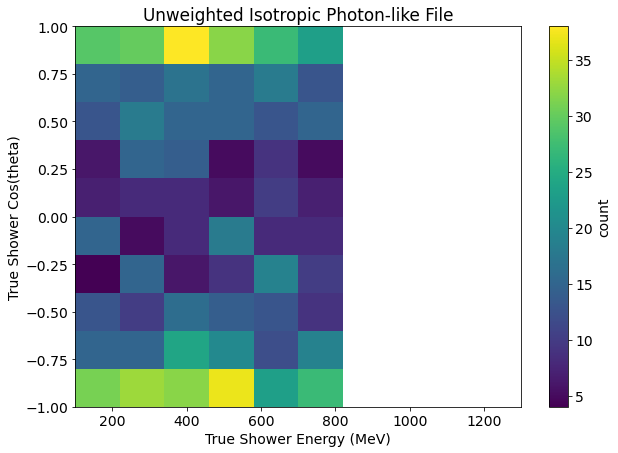

In [28]:
bins = (10, 10)
range_limits = ((100, 1300), (-1., 1.))

plt.figure(figsize=(10,7))
counts_unweighted_isotropic, _, _, _ = plt.hist2d(isotropic_df["true_total_energy"].to_numpy(), isotropic_df["total_momentum_costheta"].to_numpy(), bins=bins, range=range_limits, cmin=0.00001)
plt.colorbar(label="count")
plt.title("Unweighted Isotropic Photon-like File")
plt.xlabel("True Shower Energy (MeV)")
plt.ylabel("True Shower Cos(theta)")
plt.savefig(f"plots/unweighted_isotropic_2d.png", facecolor="white")
plt.show()

counts_unweighted_isotropic = counts_unweighted_isotropic.flatten()


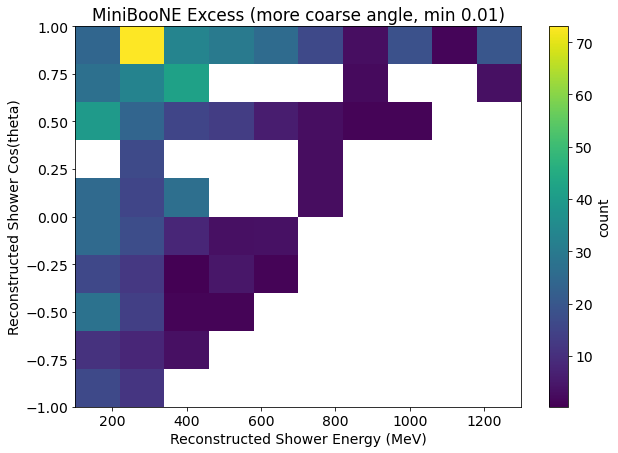

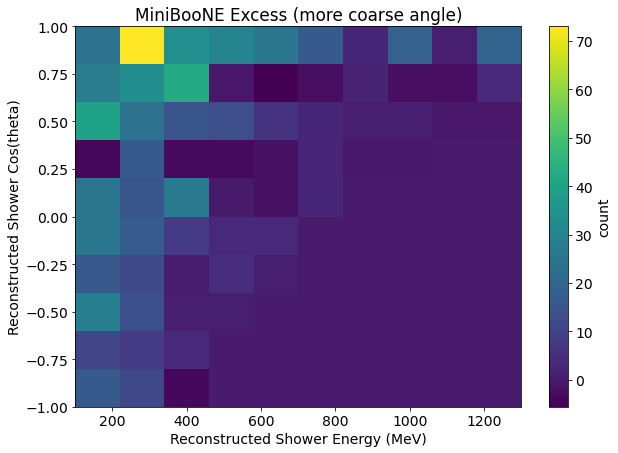

In [29]:
with open('more_coarse_miniboone_2d.pickle', 'rb') as handle:
    more_coarse_bin_centers_energy, more_coarse_bin_centers_angle, data_more_coarse, pred_more_coarse = pickle.load(handle)
    
bins = (10, 10)
range_limits = ((100, 1300), (-1., 1.))

plt.figure(figsize=(10,7))
counts_MB_excess_, _, _, _ = plt.hist2d(more_coarse_bin_centers_energy, more_coarse_bin_centers_angle, weights=(data_more_coarse - pred_more_coarse), 
                                        bins=bins, range=range_limits, cmin=0.01)
plt.colorbar(label="count")
plt.title("MiniBooNE Excess (more coarse angle, min 0.01)")
plt.xlabel("Reconstructed Shower Energy (MeV)")
plt.ylabel("Reconstructed Shower Cos(theta)")
plt.savefig(f"plots/miniboone_excess_more_coarse_2d_min_001.png", facecolor="white")
plt.show()

plt.figure(figsize=(10,7))
counts_MB_excess_, _, _, _ = plt.hist2d(more_coarse_bin_centers_energy, more_coarse_bin_centers_angle, weights=(data_more_coarse - pred_more_coarse), bins=bins, range=range_limits)
plt.colorbar(label="count")
plt.title("MiniBooNE Excess (more coarse angle)")
plt.xlabel("Reconstructed Shower Energy (MeV)")
plt.ylabel("Reconstructed Shower Cos(theta)")
plt.savefig(f"plots/miniboone_excess_more_coarse_2d.png", facecolor="white")
plt.show()

counts_MB_excess_ = counts_MB_excess_.flatten()

counts_MB_excess = []
for x in counts_MB_excess_:
    if x < 0:
        counts_MB_excess.append(0.)
    else:
        counts_MB_excess.append(x)


In [30]:
two_d_weights = [] # for each bin

true_energies = isotropic_df["true_total_energy"].to_numpy()
true_costhetas = isotropic_df["total_momentum_costheta"].to_numpy()

# finding the ratios

two_d_weights = []


angle_center = -0.9
energy_center = 160
for j in range(len(counts_unweighted_isotropic)): # looping over 2D bins
    if counts_unweighted_isotropic[j] == 0: # no isotropic events here, weight will not be used
        ratio = 0.
    elif counts_MB_excess[j] < 0:
        ratio = 0.
    else:
        ratio = counts_MB_excess[j] / counts_unweighted_isotropic[j]

    two_d_weights.append(ratio)


two_d_event_weights = []
    
# applying the ratios

for i in tqdm(range(isotropic_df.shape[0])): # looping over isotropic events
    
    #print("this event", true_energies[i], true_costhetas[i])
    
    this_event_weight = 0.
    
    #print(1, this_event_weight)
    angle_center = -0.9
    energy_center = 160
    for j in range(len(counts_unweighted_isotropic)): # looping over 2D bins
        
        #print(energy_center, angle_center)
        #print(energy_center - 120 < true_energies[i] < energy_center + 120 and angle_center - 0.1 < true_costhetas[i] < angle_center + 0.1)


        if energy_center - 60 < true_energies[i] < energy_center + 60 and angle_center - 0.1 < true_costhetas[i] < angle_center + 0.1:
            #print("found bin", energy_center - 120, true_energies[i], energy_center + 120, "and", angle_center - 0.1, true_costhetas[i], angle_center + 0.1)
            this_event_weight = two_d_weights[j]
            #print(2, this_event_weight)


               
        angle_center += 0.2
        if angle_center > 1:
            angle_center = -0.9
            energy_center += 120.

        if energy_center > 1300:
            break
    
    #print(3, this_event_weight)
    two_d_event_weights.append(this_event_weight)
    #print(this_event_weight, two_d_event_weights)
    

isotropic_df["isotropic_2d_weight"] = two_d_event_weights

total_num_2d_weighted = np.sum(isotropic_df["isotropic_2d_weight"].to_numpy())

# normalizing this to one total, so we can just multiply by the number of expected events in the end
isotropic_df["isotropic_2d_weight"] = isotropic_df["isotropic_2d_weight"].to_numpy() / total_num_2d_weighted

isotropic_df["isotropic_net_weight_interaction"] = isotropic_df["isotropic_2d_weight"].to_numpy() * total_num_expected_interaction


100%|███████████████████████████████████████████████████████████████████████████████████| 1052/1052 [00:00<00:00, 21528.25it/s]


In [31]:
print(len(two_d_weights), len(two_d_event_weights))


100 1052


In [32]:
isotropic_df["isotropic_2d_weight"].to_numpy()

array([0.        , 0.        , 0.00079746, ..., 0.00345041, 0.00449736,
       0.0019518 ])

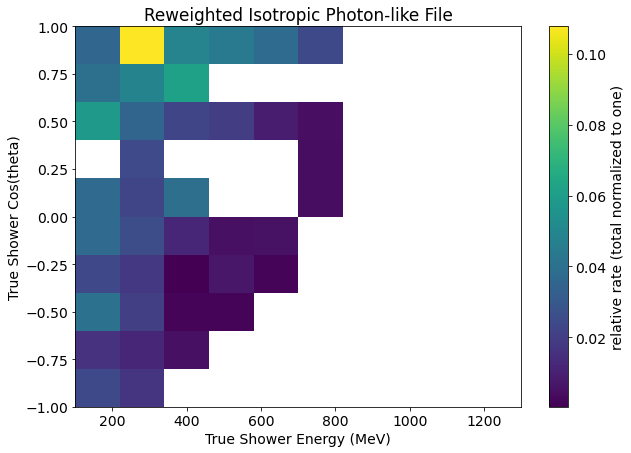

In [33]:
bins = (10, 10)
range_limits = ((100, 1300), (-1., 1.))

plt.figure(figsize=(10,7))
plt.hist2d(isotropic_df["true_total_energy"].to_numpy(), isotropic_df["total_momentum_costheta"].to_numpy(), 
                                                  weights=isotropic_df["isotropic_2d_weight"].to_numpy(), bins=bins, range=range_limits, cmin=0.00001)
plt.colorbar(label="relative rate (total normalized to one)")
plt.title("Reweighted Isotropic Photon-like File")
plt.xlabel("True Shower Energy (MeV)")
plt.ylabel("True Shower Cos(theta)")
plt.savefig(f"plots/reweighted_isotropic_2d.png", facecolor="white")
plt.show()


In [34]:

all_df = pd.concat([isotropic_df, all_df], sort=False)


In [35]:
# finally applying generic FC cut to isotropic and nc_delta files

all_df = all_df.query("kine_reco_Enu > 0 and match_isFC == 1")
data_all_df = data_all_df.query("kine_reco_Enu > 0 and match_isFC == 1")


In [36]:
all_df["shower_costheta_from_mip_angle_beam"] = np.cos(all_df["mip_angle_beam"].to_numpy() * np.pi / 180.)
data_all_df["shower_costheta_from_mip_angle_beam"] = np.cos(data_all_df["mip_angle_beam"].to_numpy() * np.pi / 180.)


In [37]:
train_vars = all_numu_scalars[:-2] + all_nue_scalars + numu_bdt_score_variables + nue_bdt_score_variables + kine_scalar_vars

model = xgb.XGBClassifier()
model.load_model("models/NC_Delta_prev_training_plus_even_subrun_ncpi0_ncdelta.model")

x = all_df[train_vars].to_numpy()
xgb_score = model.predict_proba(x)[:,1]
tvma_score = [math.tanh(_) for _ in xgb_score]
transformed_tvma_score = [math.log10((1. + _) / (1. - _)) for _ in tvma_score]
all_df["nc_delta_score"] = transformed_tvma_score

x = data_all_df[train_vars].to_numpy()
xgb_score = model.predict_proba(x)[:,1]
tvma_score = [math.tanh(_) for _ in xgb_score]
transformed_tvma_score = [math.log10((1. + _) / (1. - _)) for _ in tvma_score]
data_all_df["nc_delta_score"] = transformed_tvma_score

In [38]:
# checking that scores are calculated correctly. Needs to be xgboost v1.3 for this to work!
#all_df.query("WC_file=='nc_delta_run1' and run==7012 and subrun==847 and saved_nc_delta_score > 0")[["WC_file", "run", "subrun", "event", "nc_delta_score", "saved_nc_delta_score"]]

In [39]:
# adding proton and pion nums, adjusting em scale for reco_showerKE and kine_reco_Enu

proton_nums = []
track_nums = []
energy_lists = all_df["kine_energy_particle"].to_numpy()
pdg_lists = all_df["kine_particle_type"].to_numpy()
for i in tqdm(range(all_df.shape[0])):
    proton_num = 0
    track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
    proton_nums.append(proton_num)
    track_nums.append(track_num)
all_df["num_protons"] = proton_nums
all_df["num_other_tracks"] = track_nums


proton_nums = []
track_nums = []
corrected_kine_reco_Enus = []
energy_info_lists = data_all_df["kine_energy_info"].to_numpy()
energy_lists = data_all_df["kine_energy_particle"].to_numpy()
pdg_lists = data_all_df["kine_particle_type"].to_numpy()
add_energies = data_all_df["kine_reco_add_energy"].to_numpy()
for i in tqdm(range(data_all_df.shape[0])):
    proton_num = 0
    track_num = 0
    corrected_kine_reco_Enu = 0.
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    energy_info_list = energy_info_lists[i]
    for j in range(len(energy_list)):
        if abs(pdg_list[j]) == 2212 and energy_list[j] > 35.:
            proton_num += 1
        if abs(pdg_list[j]) == 13 or abs(pdg_list[j]) == 211 and energy_list[j] > 10.: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            track_num += 1
        if energy_info_list[j] == 2 and pdg_list[j] == 11:
            corrected_kine_reco_Enu += em_charge_scale * energy_list[j]
        else:
            corrected_kine_reco_Enu += energy_list[j]
    corrected_kine_reco_Enu += add_energies[i]
    
    corrected_kine_reco_Enus.append(corrected_kine_reco_Enu)        
    proton_nums.append(proton_num)
    track_nums.append(track_num)
data_all_df["num_protons"] = proton_nums
data_all_df["num_other_tracks"] = track_nums
data_all_df["kine_reco_Enu"] = corrected_kine_reco_Enus

uncorrected_reco_showerKE = all_df["reco_showerKE"].to_numpy()
all_df["reco_showerKE"] = uncorrected_reco_showerKE * 1000.

uncorrected_reco_showerKE = data_all_df["reco_showerKE"].to_numpy()
data_all_df["reco_showerKE"] = em_charge_scale * uncorrected_reco_showerKE * 1000.

100%|█████████████████████████████████████████████████████████████████████████████████| 90401/90401 [00:05<00:00, 17806.98it/s]


In [40]:
categories = ["MiniBooNE 2D 0-Track Photon Model", "NC Delta radiative", "NC 1 Pi0", "numuCC 1 Pi0", "nueCC", "numuCC other", "NC other", "outFV", "badmatch/cosmic", "dirt", "ext"]

queries = [
        "isIsotropic==1",
        "not (isIsotropic==1) and not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NCDelta==1",
        "not (isIsotropic==1) and not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio==1 and not (truth_NCDelta==1)",
        "not (isIsotropic==1) and not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio==1",
        "not (isIsotropic==1) and not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==12",
        "not (isIsotropic==1) and not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio!=1",
        "not (isIsotropic==1) and not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio!=1 and not (truth_NCDelta==1)",
        "not (isIsotropic==1) and not (isDirt==1) and not (isEXT==1) and match_completeness_energy/truth_energyInside>=0.1 and not (truth_vtxInside==1)",
        "not (isIsotropic==1) and not (isDirt==1) and not (isEXT==1) and not (match_completeness_energy/truth_energyInside>=0.1)",
        "isDirt==1",
        "isEXT==1",
    ]

colors = [
    "fuchsia",
    "yellow",
    "tomato",
    "royalblue",
    "orchid",
    "orange",
    "pink",
    "cyan",
    "turquoise",
    "brown",
    "limegreen"
]



In [41]:
complete_all_df = all_df.query("net_weight > 0 or isotropic_net_weight_interaction > 0") # getting rid of events with no weight, which will happen if we're excluding run 2 MC for example
complete_data_all_df = data_all_df.query("match_isFC != 0.") # should be everything, just making a copy



In [42]:
# and the global variables: queries, colors, categories

plt.rcParams.update({'font.size': 12})

def make_histograms(all_df, data_all_df, sel, x_variables, include_nc_delta_model=False, include_nc_delta_0p_model=False, extra_name=None, print_data_rses=False,
                   isotropic_weight_variable=None):
    
    # cutting to selection channel
    
    inclusive_cut = 2.61
    n_track_cut = 2.5
    zero_track_cut = 2.5
    
    all_df = complete_all_df
    data_all_df = complete_data_all_df
    
    if sel == "1gNp":
        selected_query = f"nc_delta_score > 2.61 and reco_showerKE > 0 and num_protons >= 1"
    elif sel == "1g0p":
        selected_query = f"nc_delta_score > 2.61 and reco_showerKE > 0 and num_protons == 0"
    elif sel == "1gXp":
        selected_query = f"nc_delta_score > 2.61 and reco_showerKE > 0"
    elif sel == "1g1p0pi":
        selected_query = f"nc_delta_score > 2.61 and reco_showerKE > 0 and num_protons == 1 and num_other_tracks == 0"
    elif sel == "1g0p0pi":
        selected_query = f"nc_delta_score > 2.61 and reco_showerKE > 0 and num_protons == 0 and num_other_tracks == 0"
    elif sel == "nueCC_FC":
        selected_query = f"nue_score > 7"
    elif sel == "1gNp_near_bdt":
        selected_query = f"-1.39 < nc_delta_score < 2.61 and reco_showerKE > 0 and num_protons >= 1"
    elif sel == "1g0p_near_bdt":
        selected_query = f"-1.39 < nc_delta_score < 2.61 and reco_showerKE > 0 and num_protons == 0"
    elif sel == "NC_Pi0_Np_FC":
        selected_query = f"nc_pio_score > 1.816 and num_protons >= 1"
    elif sel == "NC_Pi0_0p_FC":
        selected_query = f"nc_pio_score > 1.816 and num_protons == 0"
        
    
    selected_data_df = data_all_df.query(selected_query)
    selected_all_df = all_df.query(selected_query)
    
    #print("debug", selected_all_df.query("isIsotropic==1").shape, selected_all_df.query("isIsotropic==1")[isotropic_weight_variable].to_numpy())
    
    if print_data_rses:
        print(sel, "selected data events:")
        #display(selected_data_df[["WC_file", "run", "subrun", "event", "kine_reco_Enu", "match_isFC", "reco_showerKE", "num_protons", "num_other_tracks", "nc_delta_score", "nc_delta_ntrack_score", "nc_delta_0track_score"]])
        display(selected_data_df[["WC_file", "run", "subrun", "event", "kine_reco_Enu", "match_isFC", "reco_showerKE", 
                                  "num_protons", "num_other_tracks", "nc_delta_score"]])
    
    
    # setting x axis bins
    
    for x_variable in x_variables:
        x_variable_original_name = x_variable
        if x_variable == "reco_showerKE":
            bin_edges = np.linspace(0., 1200., 13)
        elif x_variable == "reco_showerKE_one_bin":
            bin_edges = [0, 1200.]
            x_variable = "reco_showerKE"
        elif x_variable == "reco_showerKE_gLEE_1g0p_bins":
            bin_edges = [100., 200., 250., 300., 350., 400., 450., 500., 550., 600., 700.]
            x_variable = "reco_showerKE"
        elif x_variable == "reco_showerKE_gLEE_1g1p_bins":
            bin_edges = [0., 100., 200., 300., 400., 500., 600.]
            x_variable = "reco_showerKE"
        elif x_variable == "kine_reco_Enu_nue_range":
            bin_edges = np.linspace(0., 2500, 26)
            x_variable = "kine_reco_Enu"
        elif x_variable == "kine_reco_Enu":
            bin_edges = np.linspace(0., 1500, 16)
        elif x_variable == "reco_nuvtxX":
            bin_edges = np.linspace(0., 260., 14)
        elif x_variable == "reco_nuvtxY":
            bin_edges = np.linspace(-120., 120., 13)
        elif x_variable == "reco_nuvtxZ":
            bin_edges = np.linspace(0., 1050., 14)
        elif x_variable == "reco_nu_vtx_reco_shwr_vtx_diff":
            bin_edges = [0] + list(np.logspace(-1., math.log10(10000.), 10))
        elif x_variable == "E_nu_QE":
            bin_edges = np.linspace(0., 1000., 11)
        elif x_variable == "median_dQ_dx":
            bin_edges = np.linspace(0., 0.0001, 11)
        elif x_variable == "median_dE_dx":
            bin_edges = np.linspace(0., 8., 9)
        elif x_variable == "mip_angle_beam":
            bin_edges = np.linspace(0., 180., 10)
        elif x_variable == "spt_angle_vertical":
            bin_edges = np.linspace(0., 180., 9)
        elif x_variable == "proton_theta":
            bin_edges = np.linspace(0., 180., 9)
        elif x_variable == "proton_costheta":
            bin_edges = np.linspace(-1., 1., 9)
        elif x_variable == "proton_phi":
            bin_edges = np.linspace(-180., 180., 9)
        elif x_variable == "shower_theta":
            bin_edges = np.linspace(0., 180., 9)
        elif x_variable == "shower_phi":
            bin_edges = np.linspace(-180., 180., 9)
        elif x_variable == "num_protons":
            bin_edges = np.linspace(0., 5., 6)
        elif x_variable == "num_other_tracks":
            bin_edges = np.linspace(0., 5., 6)
        elif x_variable == "shower_costheta":
            bin_edges = np.linspace(-1., 1., 9)
        elif x_variable == "shower_costheta_from_mip_angle_beam":
            bin_edges = np.linspace(-1., 0.999, 9)
        elif x_variable == "nue_score":
            bin_edges = np.linspace(-20., 14., 10)
        elif x_variable == "nc_delta_score":
            bin_edges = np.linspace(-20., 14., 10)
        elif x_variable == "nc_delta_ntrack_score":
            bin_edges = np.linspace(-20., 14., 10)
        elif x_variable == "nc_delta_0track_score":
            bin_edges = np.linspace(-20., 14., 10)
        elif x_variable == "numu_score":
            bin_edges = np.linspace(-3., 2., 10)    
        elif x_variable == "nc_pio_score":
            bin_edges = np.linspace(-3., 6., 10) 
        elif x_variable == "inwardness_2d":
            bin_edges = np.linspace(-1., 1., 11)    
        elif x_variable == "inwardness_3d":
            bin_edges = np.linspace(-1., 1., 11)  
        elif x_variable == "invariant_mass":
            bin_edges = np.linspace(500., 2000., 11)
        elif x_variable == "proton_photon_angle":
            bin_edges = np.linspace(0., 180., 9)
        elif x_variable == "proton_energy":
            bin_edges = np.linspace(0., 2000., 11)
        elif x_variable == "proton_KE":
            bin_edges = np.linspace(0., 1000., 11)
        elif x_variable == "distance_to_boundary":
            bin_edges = np.linspace(0., 130., 11)
        elif x_variable == "backwards_projected_dist":
            bin_edges = np.linspace(0., 500., 11)

        else:
            bin_edges = [-1e6, 1e6]
            
        bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2. for i in range(len(bin_edges) - 1)]
        num_bins = len(bin_edges) - 1


        # getting data points
        
        data_points, bin_edges_ = np.histogram(data_all_df.query(selected_query)[x_variable], bins=bin_edges)
        data_xerr = [(bin_edges[i + 1] - bin_edges[i]) / 2. for i in range(len(bin_edges) - 1)]
        data_yerr = [np.sqrt(x) for x in data_points]


        # picking out specific backgrounds from the selected events   

        selected_e_categories = []
        selected_w_categories = []
        for q in queries:
            selected_e_categories.append(selected_all_df.query(q)[x_variable].to_numpy())
            if q == "isIsotropic==1":
                selected_w_categories.append(selected_all_df.query(q)[isotropic_weight_variable].to_numpy())
            else:
                selected_w_categories.append(selected_all_df.query(q)["net_weight"].to_numpy())
        
        #print(queries[8])
        #print(selected_w_categories[8])
        
        # finding total prediction
            
        total_counts = []
        total_counts_unweighted = []
        for i in range(len(selected_e_categories)):
            hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=1, range=(bin_edges[0], bin_edges[-1]), weights=selected_w_categories[i])
            total_counts.append(hist_[0])
            hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=1, range=(bin_edges[0], bin_edges[-1]))
            total_counts_unweighted.append(hist_[0])

        legend_strings = [categories[i] + ", " + str(np.round(total_counts[i], 3)) + " (" + str(total_counts_unweighted[i]) + ")" for i in range(len(categories))]

        
        # plotting
        
        plt.clf()
        plt.figure(dpi=200, figsize=(10,7))

        # plotting prediction categories
        n_, bins_, patches_ = plt.hist(selected_e_categories, bins=bin_edges, weights=selected_w_categories, color=colors, label=legend_strings, stacked=True)
        
        # labeling total prediction
        plt.plot([], [], " ", label="total prediction: " + str(np.round(np.sum(total_counts), 4)))
        
        # plotting LEE models
        
        if include_nc_delta_model:
                    
            nc_delta_total_e = np.append(selected_e_categories[0], selected_e_categories[1])
            nc_delta_total_weights = np.append(selected_w_categories[0], selected_w_categories[1])

            nc_delta_model_counts, bin_edges_ = np.histogram(nc_delta_total_e, weights=nc_delta_total_weights * (nc_delta_LEE_model_factor - 1), bins=bin_edges)
            
            plt.hist(bin_centers, weights = n_[-1] + nc_delta_model_counts, bins=bin_edges, 
                     histtype="step", linestyle="dashed", linewidth=2, color="orange",
                     label=f"{round(nc_delta_LEE_model_factor, 3)}x NC Delta, {round(np.sum(nc_delta_model_counts), 3)} excess")

        if include_nc_delta_0p_model:
            
            nc_delta_0p_e = selected_e_categories[1]
            nc_delta_0p_weights = selected_w_categories[1]
            zero_p_model_counts, bin_edges_ = np.histogram(nc_delta_0p_e, weights=nc_delta_0p_weights * (zero_p_LEE_model_factor - 1), bins=bin_edges)

            plt.hist(bin_centers, weights = n_[-1] + zero_p_model_counts, bins=bin_edges, 
                     histtype="step", linestyle="dotted", linewidth=2, color="green",
                     label=f"{round(zero_p_LEE_model_factor, 3)}x NC Delta 1g 0(p,pi0,pi+/-), {round(np.sum(zero_p_model_counts), 3)} excess")


            
        plt.errorbar(bin_centers, data_points, yerr=data_yerr, xerr=data_xerr, fmt="none", capsize=5, c="black", zorder=10)

        plt.scatter(bin_centers, data_points, label=f"6.369e20 runs 1-3 BNB data, {np.sum(data_points)}", color="black", zorder=10)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        
        order = [1,2,3,4,5,6,7,8,9,10,0,11]
        
            
        order += [len(labels) - 1] # adding the last label, the data
        
        L = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=10)
        L.set_zorder(20)


        # label x axis
        
        if x_variable == "kine_reco_Enu":
            plt.xlabel("Reconstructed Neutrino Energy (MeV)")
        elif x_variable == "reco_showerKE":
            plt.xlabel("Shower Energy (MeV)")
        elif x_variable == "reco_nuvtxX":
            plt.xlabel("Reconstructed Neutrino Vertex X (cm)")
        elif x_variable == "reco_nuvtxY":
            plt.xlabel("Reconstructed Neutrino Vertex Y (cm)")
        elif x_variable == "reco_nuvtxZ":
            plt.xlabel("Reconstructed Neutrino Vertex Z (cm)")
        elif x_variable == "reco_nu_vtx_reco_shwr_vtx_diff":
            plt.xlabel("Distance Between Reco Neutrino Vertex\nand Reco Shower Vertex (cm)")
            plt.yscale("log")
            plt.xscale('symlog', linthresh=1)
            plt.xlim(0., 10000.)
        elif x_variable == "mip_angle_beam":
            plt.xlabel("shower-beam angle (degrees)")
        elif x_variable == "spt_angle_vertical":
            plt.xlabel("shower-vertical angle (degrees)")
        elif x_variable == "E_nu_QE":
            plt.xlabel("E_nu_QE (MeV)")
        elif x_variable == "median_dE_dx":
            plt.xlabel("Primary Shower Stem Median dE/dx (MeV/cm)")
        elif x_variable == "proton_theta":
            plt.xlabel("Proton Polar Angle (degrees)")
        elif x_variable == "proton_costheta":
            plt.xlabel("Proton cos(theta)")
        elif x_variable == "proton_phi":
            plt.xlabel("Proton Azimuthal Angle (degrees)")
        elif x_variable == "num_protons":
            plt.xlabel("Reco Proton Multiplicity\n(35 MeV threshold, primary or non-primary)")
        elif x_variable == "num_other_tracks":
            plt.xlabel("Reco Non-proton Track Multiplicity\n(10 MeV threshold, primary or non-primary)")
        elif x_variable == "shower_costheta" or x_variable == "shower_costheta_from_mip_angle_beam":
            plt.xlabel("Primary Shower Cos(theta)")
        elif x_variable == "shower_theta":
            plt.xlabel("Primary Shower theta")
        elif x_variable == "shower_phi":
            plt.xlabel("Primary Shower Phi")
        elif x_variable == "invariant_mass":
            plt.xlabel("photon-proton invariant mass")
        elif x_variable == "proton_photon_angle":
            plt.xlabel("proton-photon opening angle (degrees)")
        elif x_variable == "proton_energy":
            plt.xlabel("Proton Energy (MeV)")
        elif x_variable == "proton_KE":
            plt.xlabel("Proton Kinetic Energy (MeV)")
        elif x_variable == "distance_to_boundary":
            plt.xlabel("Distance to Active Volume Boundary (cm)")
        elif x_variable == "backwards_projected_dist":
            plt.xlabel("Backwards-Projected Distance to Active Volume Boundary (cm)")
        else:
            plt.xlabel(x_variable)
        
        plt.title(f"{sel} selection")
        plt.ylabel("count")

        # saving figure
        if extra_name:
            plt.title(f"{sel} selection {extra_name}")
        
            plt.savefig(f"plots/{sel}_{x_variable_original_name}_{extra_name}.png", facecolor="white")
        else:
            plt.savefig(f"plots/{sel}_{x_variable_original_name}.png", facecolor="white")
            

        plt.clf()
        

def make_score_distribution(all_df, data_all_df, x_variable, extra_cut="", include_nc_delta_model=False, include_nc_delta_0p_model=False, extra_name=None,
                            isotropic_weight_variable=None):
    
    selected_query = "kine_reco_Enu > 0 and match_isFC==1 and reco_showerKE > 0" + extra_cut
    
    # TEMPORARY
    #selected_query = "kine_reco_Enu >=0 and match_isFC==1 and nc_pio_score > 1.816" + extra_cut

    
    selected_data_df = data_all_df.query(selected_query)
    selected_all_df = all_df.query(selected_query)
    
    if x_variable == "nc_delta_score":
        bin_edges = np.linspace(-17.5 + 0.11, 10.5 + 0.11, 15)
    else:
        bin_edges = np.linspace(-17.5, 10.5, 15)

    
    #print(bin_edges)
    
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2. for i in range(len(bin_edges) - 1)]
    num_bins = len(bin_edges) - 1

    # getting data points
    data_points, bin_edges_ = np.histogram(selected_data_df[x_variable], bins=bin_edges)
    data_xerr = [(bin_edges[i + 1] - bin_edges[i]) / 2. for i in range(len(bin_edges) - 1)]
    data_yerr = [np.sqrt(x) for x in data_points]


    # picking out specific backgrounds from the selected events   
    selected_e_categories = []
    selected_w_categories = []
    for q in queries:
        selected_e_categories.append(selected_all_df.query(q)[x_variable].to_numpy())
        if q == "isIsotropic==1":
            selected_w_categories.append(selected_all_df.query(q)[isotropic_weight_variable].to_numpy())
        else:
            selected_w_categories.append(selected_all_df.query(q)["net_weight"].to_numpy())



    # finding total prediction

    total_counts = []
    total_counts_unweighted = []
    for i in range(len(selected_e_categories)):
        hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=1, range=(bin_edges[0], bin_edges[-1]), weights=selected_w_categories[i])
        total_counts.append(hist_[0])
        hist_, bin_edges_ = np.histogram(selected_e_categories[i], bins=1, range=(bin_edges[0], bin_edges[-1]))
        total_counts_unweighted.append(hist_[0])

    legend_strings = [categories[i] + ", " + str(np.round(total_counts[i], 3)) + " (" + str(total_counts_unweighted[i]) + ")" for i in range(len(categories))]

    
    # plotting
        
    plt.clf()
    plt.figure(dpi=200, figsize=(10,7))
    ax1 = plt.subplot(3,1,(1,2))
    
    # plotting prediction categories
    n_, bins_, patches_ = plt.hist(selected_e_categories, bins=bin_edges, weights=selected_w_categories, color=colors, label=legend_strings, stacked=True)

    # labeling total prediction
    plt.plot([], [], " ", label="total prediction: " + str(np.round(np.sum(total_counts), 4)))

    # plotting LEE models

    if include_nc_delta_model:

        nc_delta_total_e = np.append(selected_e_categories[0], selected_e_categories[1])
        nc_delta_total_weights = np.append(selected_w_categories[0], selected_w_categories[1])

        nc_delta_model_counts, bin_edges_ = np.histogram(nc_delta_total_e, weights=nc_delta_total_weights * (nc_delta_LEE_model_factor - 1), bins=bin_edges)

        plt.hist(bin_centers, weights = n_[-1] + nc_delta_model_counts, bins=bin_edges, 
                 histtype="step", linestyle="dashed", linewidth=2, color="orange",
                 label=f"{round(nc_delta_LEE_model_factor, 3)}x NC Delta, {round(np.sum(nc_delta_model_counts), 3)} excess")

    if include_nc_delta_0p_model:

        nc_delta_0p_e = selected_e_categories[1]
        nc_delta_0p_weights = selected_w_categories[1]
        zero_p_model_counts, bin_edges_ = np.histogram(nc_delta_0p_e, weights=nc_delta_0p_weights * (zero_p_LEE_model_factor - 1), bins=bin_edges)

        plt.hist(bin_centers, weights = n_[-1] + zero_p_model_counts, bins=bin_edges, 
                 histtype="step", linestyle="dotted", linewidth=2, color="green",
                 label=f"{round(zero_p_LEE_model_factor, 3)}x NC Delta 1g 0(p,pi0,pi+/-), {round(np.sum(zero_p_model_counts), 3)} excess")



    plt.errorbar(bin_centers, data_points, yerr=data_yerr, xerr=data_xerr, fmt="none", capsize=5, c="black", zorder=10)


    plt.scatter(bin_centers, data_points, label=f"6.369e20 runs 1-3 BNB data, {np.sum(data_points)}", color="black", zorder=10)

    inclusive_cut = 2.61
    n_track_cut = 2.5
    zero_track_cut = 2.5
    
    if x_variable == "nc_delta_ntrack_score":
        plt.axvline(n_track_cut, label="N Track BDT Cut Value", c="black", ls="--")
    elif x_variable == "nc_delta_0track_score":
        plt.axvline(zero_track_cut, label=f"Zero Track BDT Cut Value of {zero_track_cut}", c="black", ls="--")
    elif x_variable == "nc_delta_score":
        plt.axvline(inclusive_cut, label=f"BDT Cut Value of {inclusive_cut}", c="black", ls="--")
    else:
        plt.xlabel(x_variable)
            

            
            
    handles, labels = plt.gca().get_legend_handles_labels()
    

    order = [1,2,3,4,5,6,7,8,9,10,0,11,12]

    order += [len(labels)-1] # adding the last labels, the data and the bdt cut value


    L = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=10)
    L.set_zorder(20)


    plt.ylabel("count")
    plt.yscale("log")
    
    # TEMPORARY
    #plt.title(f"NC Pi0 FC {extra_name} events")
    if extra_name:
        plt.title(f"Generic, FC, Positive Shower Energy, {extra_name} events")
    else:
        plt.title(f"Generic, FC, Positive Shower Energy events")

    
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax2 = plt.subplot(3,1,3, sharex=ax1)
    predictions = n_[-1]
    ratios = [data_points[i] / predictions[i] for i in range(num_bins)]
    ratios_errs = [data_yerr[i] / predictions[i] for i in range(num_bins)]
    plt.errorbar(bin_centers, ratios, yerr=ratios_errs, xerr=data_xerr, fmt="none", capsize=2, c="black", zorder=10)
    plt.scatter(bin_centers, ratios, color="black", zorder=10)
    #plt.xlabel("NC Delta Radiative score")
    plt.ylabel("data/prediction")

    plt.ylim((0, 3))
    plt.grid()
    
    if x_variable == "nc_delta_ntrack_score":
        plt.xlabel("N Track BDT Score")
        plt.axvline(n_track_cut, c="black", ls="--")
    elif x_variable == "nc_delta_0track_score":
        plt.xlabel("0 Track BDT Score")
        plt.axvline(zero_track_cut, c="black", ls="--")
    elif x_variable == "nc_delta_score":
        plt.axvline(inclusive_cut, c="black", ls="--")
        plt.xlabel("Inclusive BDT Score")
    else:
        plt.xlabel(x_variable)
    
    x_variable_original_name = x_variable

    # saving figure
    if extra_name:


        plt.savefig(f"plots/{x_variable_original_name}_{extra_name}.png", facecolor="white")

    else:

        plt.savefig(f"plots/{x_variable_original_name}_{extra_name}.png", facecolor="white")
        

    plt.clf()
        



In [43]:
#pd.set_option('display.max_rows', None)

#make_histograms(all_df, data_all_df, "1g0p", ["kine_reco_Enu"], include_nc_delta_model=False, 
#                include_nc_delta_0p_model=False, isotropic_weight_variable="isotropic_net_weight_interaction", print_data_rses=True)



In [44]:
make_score_distribution(all_df, data_all_df, "nc_delta_score", extra_cut=" and num_protons >= 1", extra_name="Np", 
                        isotropic_weight_variable="isotropic_net_weight_interaction")
make_score_distribution(all_df, data_all_df, "nc_delta_score", extra_cut=" and num_protons == 0", extra_name="0p",
                        isotropic_weight_variable="isotropic_net_weight_interaction")

make_histograms(all_df, data_all_df, "1gNp", ["reco_showerKE", "kine_reco_Enu", "reco_showerKE_one_bin", "shower_costheta_from_mip_angle_beam"], include_nc_delta_model=False, 
                include_nc_delta_0p_model=False, isotropic_weight_variable="isotropic_net_weight_interaction")
make_histograms(all_df, data_all_df, "1g0p", ["reco_showerKE", "kine_reco_Enu", "reco_showerKE_one_bin", "shower_costheta_from_mip_angle_beam"], include_nc_delta_model=False, 
                include_nc_delta_0p_model=False, isotropic_weight_variable="isotropic_net_weight_interaction")


/home/hagaman/anaconda3/envs/three_point_seven_env/lib/python3.7/site-packages/ipykernel_launcher.py:437: RuntimeWarning: invalid value encountered in true_divide
/home/hagaman/anaconda3/envs/three_point_seven_env/lib/python3.7/site-packages/ipykernel_launcher.py:438: RuntimeWarning: invalid value encountered in double_scalars
/home/hagaman/anaconda3/envs/three_point_seven_env/lib/python3.7/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/hagaman/anaconda3/envs/three_point_seven_env/lib/python3.7/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/hagaman/anaconda3/envs/three_point_seven_env/lib/python3.7/site-packages/ipykernel_launcher.py:437: RuntimeWarning: invalid value encountered in true_divide
/home/hagaman/anaconda3/envs/three_point_seven_env/lib/pyt

<Figure size 432x288 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

<Figure size 2000x1400 with 0 Axes>

In [45]:
"""isotropic_df = all_df.query("isIsotropic==1")

isotropic_count = []
bin_size_mixed = []

mixed_bin_centers_angle = []
mixed_bin_centers_energy = []

angle_center = -0.95
energy_center = 130

while True:
        
    mixed_bin_centers_angle.append(angle_center)
    mixed_bin_centers_energy.append(energy_center)
    
    
    if angle_center < 0.9:
        isotropic_count.append(isotropic_df.query(f"{energy_center - 30} < true_total_energy < {energy_center + 30}"
                                             + f" and {angle_center - 0.05} < total_momentum_costheta < {angle_center + 0.05}").shape[0])
        bin_size_mixed.append(0.1 * 60)
    else: # combine coarse and fine data in a way that's consistent with both histograms
        isotropic_count.append(isotropic_df.query(f"{energy_center - 30} < true_total_energy < {energy_center + 30}"
                                             + f" and {angle_center - 0.005} < total_momentum_costheta < {angle_center + 0.005}").shape[0])
        bin_size_mixed.append(0.01 * 60)

    if round(angle_center, 3) == 0.85: # about to switch from the coarse part to the fine part
        angle_center = 0.905
    elif round(angle_center, 3) == 0.995:
        
        if energy_center == 1270:
            break
        
        angle_center = -0.95
        energy_center += 60
    elif angle_center > 0.9:
        angle_center += 0.01
    else:
        angle_center += 0.1
    
isotropic_count = np.array(isotropic_count)
bin_size_mixed = np.array(bin_size_mixed)

bins = (
    [100 + i * 60 for i in range(21)],
    (-1., -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 
     0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.)
)
range_limits = ((100., 1300.), (-1., 1.))

plt.figure(figsize=(10,7))
plt.hist2d(mixed_bin_centers_energy, mixed_bin_centers_angle, weights=isotropic_count / bin_size_mixed, bins=bins, range=range_limits, cmin=0.00001)
plt.colorbar(label="count per cos(theta) MeV")
plt.title("Unweighted Isotropic Photon-like File")
plt.xlabel("True Shower Energy (MeV)")
plt.ylabel("True Shower Cos(theta)")
plt.show()"""

'isotropic_df = all_df.query("isIsotropic==1")\n\nisotropic_count = []\nbin_size_mixed = []\n\nmixed_bin_centers_angle = []\nmixed_bin_centers_energy = []\n\nangle_center = -0.95\nenergy_center = 130\n\nwhile True:\n        \n    mixed_bin_centers_angle.append(angle_center)\n    mixed_bin_centers_energy.append(energy_center)\n    \n    \n    if angle_center < 0.9:\n        isotropic_count.append(isotropic_df.query(f"{energy_center - 30} < true_total_energy < {energy_center + 30}"\n                                             + f" and {angle_center - 0.05} < total_momentum_costheta < {angle_center + 0.05}").shape[0])\n        bin_size_mixed.append(0.1 * 60)\n    else: # combine coarse and fine data in a way that\'s consistent with both histograms\n        isotropic_count.append(isotropic_df.query(f"{energy_center - 30} < true_total_energy < {energy_center + 30}"\n                                             + f" and {angle_center - 0.005} < total_momentum_costheta < {angle_center + 0.00